# Mechanical effect produced by photo-switchable reactions: Insights from molecular simulations

In [1]:
# Reload all modules
# This is useful when you need to edit a module without
# closing the notebook.

%load_ext autoreload
%autoreload 2

In [2]:
# Load common modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import glob
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import itertools as it
from scipy.constants import N_A
import statistics
import statsmodels.api as sm

from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

import pyblock

In [3]:
# Modules STAMPTOOLS
from stamptools.analysis import load_data, get_distances_from_cm, rdf_from_dist, load_log
from stamptools.stamp import STAMP
from stamptools.stamptools import read_geometry_file

In [4]:
# submodule stamptools with notebooks tools
from stamptools import nbconfig
from stamptools.nbconfig import rot, get_acorr, stretched_exponetial, get_log2_av, ImagesCount
from stamptools.nbconfig import textKwargs, save_fig

In [5]:
# Load my parameters in the matplotlib setting
plt.rcParams.update(nbconfig.MplotParam)

In [ ]:
#for par in mpl.rcParams:
#    if "axes" in par:
#        print(par,":", mpl.rcParams[par])

mpl.rcParams

In [7]:
# Main folder
toFigures = "/home/ovillegas/figures/figPapers"
home_stamp="/home/ovillegas/exp.azob.stamp.3"
home_gro="/home/ovillegas/exp.azob.gmx"

send_to_aurelie="/home/ovillegas/send2Aurelie"

In [7]:
def saveFig(name):
    return nbconfig.save_fig(name, send_to_aurelie)

In [8]:
SAVEFig = ImagesCount(toFigures)

Initialization of the image tracker
Output folder: /home/ovillegas/figures/figPapers


In [9]:
SAVEFig.showInfo()

Output folder: /home/ovillegas/figures/figPapers
Count: 0


### Format definitions

In [10]:
labels = {"trans":"$trans$", "cis":r"$cis$", "s1":"S$_1$", "pb": r"$polymer$"}

systems = ["trans", "cis"]

replicas = ["0", "1", "2", "3", "4"]

colors = {"THF": "tab:blue", "PB": "tab:orange", "PB-OH": "purple"}

In [11]:
POLPROP2 = {
    "Rg": {
        "color": "#2a90a6",
        "binwidth": .1,
        "xlim": [0.5, 3.0],
        "label": "Radius of gyration (nm)",
        "units": "nm",
        "clim": [.0, 0.1]
    },
    "dmax": {
        "color": "#5b557b",
        "binwidth": .3,
        "xlim": [1.0, 9.0],
        "label": "Max. distance (nm)",
        "units": "nm",
        "clim": [.0, 0.1]
    },
    "k2": {
        "color": "#fea6ad",
        "binwidth": .05,
        "xlim": [0, 1],
        "label": "Shape anisotropy",
        "units": "",
        "clim": [.0, 0.1]
    },
    "rdf": {
        "color": "#3293f0",
        "xlim": [0.25, 2.5],
        "label": "g(r) PC - PB",
        "units": ""
        
    },
    "rdf_CM": {
        "color": "purple",
        "xlim": [0.25, 2.5],
        "label": r"g(r) PC$_{CM}$ - PB$_{CM}$",
        "units": ""
        
    },
    "distance": {
        "color": "#66c0c0",
        "binwidth": .01,
        "xlim": [0.1, 1.0],
        "label": "distance",
        "units": "nm"
    }
}

## Impact of the Polymeric Matrix on the Photochrome

### Photochrome geometry

#### parameters definitions

In [24]:
Param_cnnc = {
    "trans":{
        "step": 1.0,
        "center": 180.0,
        "edge": 20.0,
        "deg": 0.0
    },
    "cis":{
        "step": 1.0,
        "center": 0.0,
        "edge": 20.0,
        "deg": -90.0
    },
    "s1":{
        "step": 1.0,
        "center": 0.0,
        "edge": 180.0,
        "deg": -180.0
    }
}

Param_cnn = {
    "trans":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 115.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "cis":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 110.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "s1":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 125.0,
        "edge": 20.0,
        "deg": -100.0
    }
}

Param_ccnn = {
    "trans":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -90.0
    },
    "cis":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 0.0,
        "edge": 210.0,
        "deg": -180.0
    },
    "s1":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -100.0
    }
}

Param_color = {
    "PB": "#fca561",
    "THF": "#39b1c5"
}

Param_style = {
    "PB": ".",
    "THF": "x"
}

#### PC - PB

In [25]:
# Load all file with Geometry information
GEOM = {
    "PB": {"trans": {}, "cis": {}, "s1": {}},
    "THF": {"trans": {}, "cis": {}, "s1": {}}
}

for system in GEOM:
    for iso in ["trans", "cis", "s1"]:
        for r in replicas: 
            if system == "PB":
                path_file = "{}/{}/6_prod_{}/Geometry_mol.csv".format(home_stamp, iso, r)
            elif system == "THF":
                path_file = "{}/{}.thf/{}/md/Geometry_mol.csv".format(home_gro, iso, r)
            
            ## print(system, iso, r, path_file)
            data = read_geometry_file(
                path_file,
                freq=1.,
                t0=1.
                )

            if iso == "trans" or iso == "s1":
                data["d_ccnn_1"] = data["d_ccnn_1"].apply(nbconfig.rot, deg=-100)
                data["d_ccnn_3"] = data["d_ccnn_3"].apply(nbconfig.rot, deg=-100)
                data["d_ccnn_2"] = data["d_ccnn_2"].apply(nbconfig.rot, deg=-100)
                data["d_ccnn_4"] = data["d_ccnn_4"].apply(nbconfig.rot, deg=-100)
            
            GEOM[system][iso][r] = data.copy()


GEOMtot = {}
for system in GEOM:
    GEOMtot[system] = {}
    for iso in GEOM[system]:
        GEOMtot[system][iso] = []
        for r in GEOM[system][iso]:
            GEOMtot[system][iso].append(GEOM[system][iso][r])

        GEOMtot[system][iso] = pd.concat(GEOMtot[system][iso], ignore_index=True)


Image 19 saved!
/home/ovillegas/figures/figPapers/img_0019_geom_tor_cnnc_all_2.png


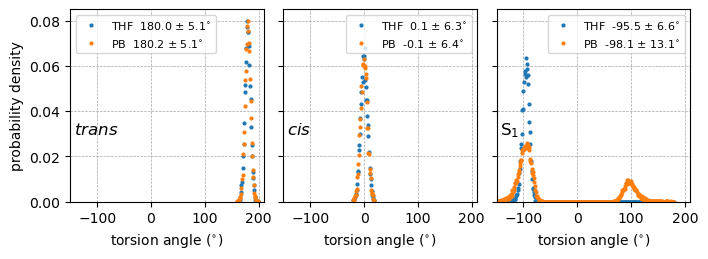

In [38]:
torsion = "d_cnnc"
grid_lines_x = np.arange(0, 0.1 + 0.01, 0.01)
grid_lines_y = np.arange(-150, 200 + 50, 50)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8,2.5))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

#fig.suptitle(
#    f"Torsion C-N=N-C",
#    fontweight="bold",
#    fontsize=14,
#    y=0.92,
#    x=0.5,
#    ha = "center"
#)

systems = ['trans', 'cis', "s1"]

for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        data[torsion] = data[torsion].apply(lambda x: rot(x, Param_cnnc[isomer]["deg"]))
        bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
        hist, _ = np.histogram(data[torsion], bins=bins, density=True)
        if isomer == "s1":
            ndata = data[data[torsion] < Param_cnnc[isomer]["center"]]
        else:
            ndata = data.copy()
        ax[i].plot(
            bins[:-1],
            hist, ".",
            label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color = colors[sol],
            ms = 4.
        )
        
    ax[i].set_xlim(-150., 210.)
    ax[i].set_ylim(0., 0.085)

    ax[i].text(
            0.02, 0.35,
            "{}".format(labels[isomer]),
            transform=ax[i].transAxes,
            **textKwargs
        )
    # ax[i].set_title(t)
    ax[i].legend(fontsize=8)
    ax[i].set_xlabel(r"torsion angle ($^{\circ}$)", fontsize=10)
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    if i != 0:
        ax[i].set_yticklabels([])

    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        
    # ax[i].set_yticks([0., 0.04, 0.08])
    if i == 0:
        ax[i].set_ylabel("probability density", fontsize=10)
        

SAVEFig.saveFig("geom_tor_cnnc_all_2.png")
# saveFig(f"torsion_cnnc_all.png")
# SaveFigPaper.saveFig(f"torsion_{torsion}_all_new.png")
plt.show()

Distributions observed for dihedrals CNNC and compared for each isomer in PB and THF.

In [ ]:
torsion = "d_cnnc"

fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(7,6))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

#fig.suptitle(
#    f"Torsion C-N=N-C",
#    fontweight="bold",
#    fontsize=14,
#    y=0.92,
#    x=0.5,
#    ha = "center"
#)

systems = ['trans', 'cis', "s1"]

for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        data[torsion] = data[torsion].apply(lambda x: rot(x, Param_cnnc[isomer]["deg"]))
        bins = np.arange(
            Param_cnnc[isomer]["center"] - Param_cnnc[isomer]["edge"],
            Param_cnnc[isomer]["center"] + Param_cnnc[isomer]["edge"] + Param_cnnc[isomer]["step"],
            Param_cnnc[isomer]["step"]
        )
        hist, _ = np.histogram(data[torsion], bins=bins, density=True)
        if isomer == "s1":
            ndata = data[data[torsion] < Param_cnnc[isomer]["center"]]
        else:
            ndata = data.copy()
        ax[i].plot(
            bins[:-1],
            hist, ".",
            label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color = colors[sol],
            ms = 4.
        )
        
    ax[i].set_xlim(-150., 210.)
    ax[i].set_ylim(0., 0.085)

    ax[i].text(
            0.02, 0.35,
            "{}".format(labels[isomer]),
            transform=ax[i].transAxes,
            **textKwargs
        )
    # ax[i].set_title(t)
    ax[i].legend()
    ax[i].set_xlabel(r"torsion angle ($^{\circ}$)")
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    if i != 2:
        ax[i].set_xticklabels([])

    # ax[i].xaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        
    # ax[i].set_yticks([0., 0.04, 0.08])
    if i == 1:
        ax[i].set_ylabel("probability density")
        

SAVEFig.saveFig("geom_tor_cnnc_all.png")
# saveFig(f"torsion_cnnc_all.png")
# SaveFigPaper.saveFig(f"torsion_{torsion}_all_new.png")
plt.show()

Image 2 saved!
/home/ovillegas/figures/figPapers/img_0002_geom_tor_ccnn_all.png


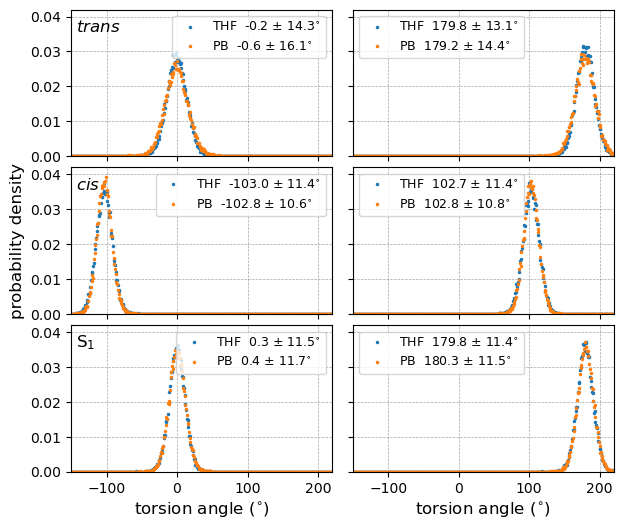

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(7,6))

fig.subplots_adjust(hspace=0.08, wspace=0.08)

t_ccnn_ts_THF = {
    "ccnn0": ["d_ccnn_2", "d_ccnn_3"],
    "ccnn180": ["d_ccnn_1", "d_ccnn_4"]
}

t_ccnn_ts_PB = {
    "ccnn0": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn180": ["d_ccnn_2", "d_ccnn_4"]
}

torsion_ccnn_t = {"PB": t_ccnn_ts_PB, "THF": t_ccnn_ts_THF}

t_ccnn_c_THF = {
    "ccnn_p": ["d_ccnn_2", "d_ccnn_3"],
    "ccnn_m": ["d_ccnn_1", "d_ccnn_4"]
}

t_ccnn_c_PB = {
    "ccnn_p": ["d_ccnn_1", "d_ccnn_3"],
    "ccnn_m": ["d_ccnn_2", "d_ccnn_4"]
}

torsion_ccnn_c = {"PB": t_ccnn_c_PB, "THF": t_ccnn_c_THF}

systems = ['trans', 'cis', "s1"]

torsions_types = [
    ["ccnn0", "ccnn180"],
    ["ccnn_m", "ccnn_p"],
    ["ccnn0", "ccnn180"]
]

for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        for j in range(2):
            torsion = torsions_types[i][j]
            
            bins = np.arange(
                0.0 - 230.,
                0.0 + 230. + 1.0,
                1.0
            )
            
            if isomer == "trans":
                vals_t = np.array(list(data[torsion_ccnn_t[sol][torsion][0]].values) + list(data[torsion_ccnn_t[sol][torsion][1]].values))
                
            elif isomer == "s1":
                vals_t = np.array(list(data[torsion_ccnn_t["PB"][torsion][0]].values) + list(data[torsion_ccnn_t["PB"][torsion][1]].values))
                
            elif isomer == "cis":
                vals_t = np.array(list(data[torsion_ccnn_c[sol][torsion][0]].values) + list(data[torsion_ccnn_c[sol][torsion][1]].values))    
            
            hist, _ = np.histogram(vals_t, bins=bins, density=True)
            
            if isomer == "trans" and sol == "THF":
                if j == 0:
                    ndata = vals_t[vals_t < 90.]
                elif j == 1:
                    ndata = vals_t[vals_t > 90.]
            else:
                ndata = vals_t.copy()
                
            ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 3,
                label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata.mean(), ndata.std()),
                color = colors[sol]
            )
            ax[i, j].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
            if i != 2:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_xticklabels([])
                
            if j == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].set_yticklabels([])

            ax[i, j].set_xlim(-150., 220.)
            # ax[i, j].set_ylim(ymin=0.)
            ax[i, j].legend(fontsize=9)
            ax[i, j].set_xlabel(r"torsion angle ($^{\circ}$)")
            
            ax[i, j].set_ylim(0., 0.042)
            # ax[i, j].set_yticks([])
            
    ax[i, 0].text(
        0.02, 0.85,
        "{}".format(labels[isomer]), transform=ax[i, 0].transAxes,
        **textKwargs
    )
    
ax[1, 0].set_ylabel("probability density")
            
            
# saveFig(f"torsion_ccnn_all.png")
# SaveFigPaper.saveFig(f"torsion_d_ccnn_2_all.png")
SAVEFig.saveFig("geom_tor_ccnn_all.png")
plt.show()

Distributions observed for dihedrals CCNN and compared for each isomer in PB and THF

Image 3 saved!
/home/ovillegas/figures/figPapers/img_0003_geom_ang_cnn_all.png


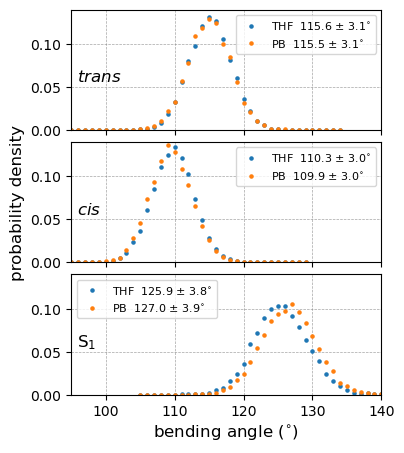

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(4,5))

fig.subplots_adjust(hspace=0.1, wspace=0.1)

systems = ['trans', 'cis', "s1"]
for i, isomer in enumerate(systems):
    for sol in ["THF", "PB"]:
        data = GEOMtot[sol][isomer].copy()
        
        vals = np.array(list(data["a_cnn_1"]) + list(data["a_cnn_1"]))
        
        bins = np.arange(
                Param_cnn[isomer]["center"] - Param_cnn[isomer]["edge"],
                Param_cnn[isomer]["center"] + Param_cnn[isomer]["edge"] + Param_cnn[isomer]["step"],
                Param_cnn[isomer]["step"]
            )
        
        hist, _ = np.histogram(vals, bins=bins, density=True)
        ax[i].plot(
                bins[:-1],
                hist, ".", ms = 4.5,
                label = sol + r"  %.1f $\pm$ %.1f$^{\circ}$" % (vals.mean(), vals.std()),
                color = colors[sol]
        )
                
        if i != 2:
            ax[i].set_xticklabels([])
            
        #if j == 1:
        #    # ax[i, j].get_xaxis().set_visible(False)
        #    ax[i].set_yticklabels([])

        ax[i].set_xlim(95., 140.)
        #ax[i, j].set_ylim(ymin=0.)
        ax[i].legend(fontsize=8)
        ax[i].set_xlabel(r"bending angle ($^{\circ}$)")
            
        ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
        ax[i].set_ylim(0., 0.14)
        # ax[i, j].set_yticks([])

    ax[i].text(
        0.02, 0.4,
        "{}".format(labels[isomer]), transform=ax[i].transAxes,
        **textKwargs
    )
    
ax[1].set_ylabel("probability density")
            
# saveFig(f"angle_cnn_all.png")
# SaveFigPaper.saveFig(f"angle_a_cnn_all.png")
SAVEFig.saveFig("geom_ang_cnn_all.png")
plt.show() 

Distributions observed for angles CNN and compared for each isomer in PB and THF

#### PC - PBOH

In [17]:
# Load all file with Geometry information
GEOMoh = {
    "PB": {"trans": {}, "cis": {}},
    "PB-OH": {"trans": {}, "cis": {}}
}

for system in GEOMoh:
    for iso in GEOMoh[system]:
        for r in replicas:
            freq = 1.
            t0 = 1.
            
            if system == "PB":
                path_file = "{}/{}/6_prod_{}/Geometry_mol.csv".format(home_stamp, iso, r)
            elif system == "PB-OH":
                path_file = "{}/{}/9_prod_OH_{}/Geometry_mol.csv".format(home_stamp, iso, r)
                freq = 0.1
                t0 = 0.1

            data = read_geometry_file(
                path_file,
                freq=freq,
                t0=t0
                )
            GEOMoh[system][iso][r] = data.copy()

GEOMtotoh = {}

for system in GEOMoh:
    GEOMtotoh[system] = {}
    for iso in GEOMoh[system]:
        GEOMtotoh[system][iso] = []
        for r in GEOMoh[system][iso]:
            GEOMtotoh[system][iso].append(GEOMoh[system][iso][r])

        GEOMtotoh[system][iso] = pd.concat(GEOMtotoh[system][iso], ignore_index=True)

In [18]:
GEOMtotoh["THF"] = GEOMtot["THF"]

In [19]:
properties = {
    "r_oh": {
        "text": r"$r_{OH}$",
        "bins": np.arange(.8, 1.11, 0.01),
        "xlim": [0.76, 1.10],
        "xlabel": "distance ($\AA$)",
        "ylim": [0.0, 15.0]
    },
    "a_coh": {
        "text": r"$a_{COH}$",
        "bins": np.arange(90., 125, 0.5),
        "xlim": [80, 120],
        "xlabel": "angle ($^{\circ}$)",
        "ylim": [0.0, 0.1]
    },
    "r_cc": {
        "text": r"$r_{C_{Ar}--C_{Ar}}$",
        "bins": np.arange(1.8, 4, 0.01),
        "xlim": [1.9, 3.8],
        "xlabel": "distance ($\AA$)",
        "ylim": [0.0, 8.4]
    }
}

In [20]:
from matplotlib.ticker import FormatStrFormatter

Image 4 saved!
/home/ovillegas/figures/figPapers/img_0004_geom_dist_ang_PBOH.png


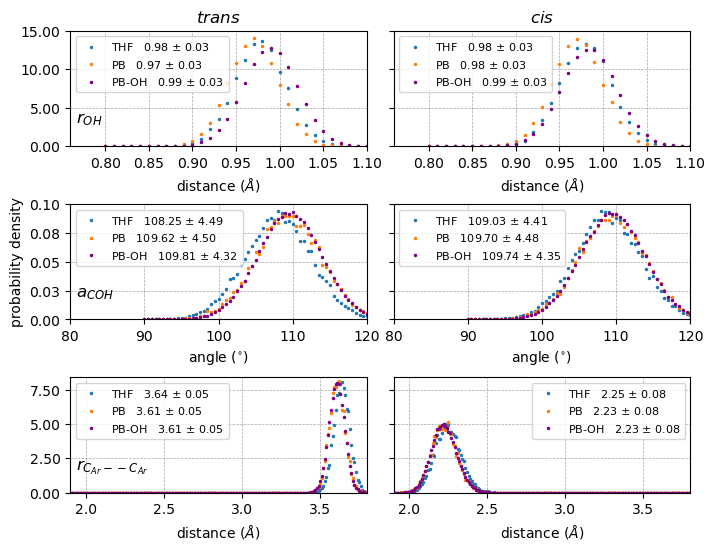

In [21]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8,6))

fig.subplots_adjust(hspace=0.5, wspace=0.09)

for i, iso in enumerate(["trans", "cis"]):
    ax[0, i].set_title(labels[iso])
    
    for j, prop in enumerate(properties):
        ax[j, 0].text(
            0.02, 0.2,
            properties[prop]["text"],
            transform=ax[j, i].transAxes,
            **textKwargs
        )
        
        for sol in ["THF", "PB", "PB-OH"]:
            data = GEOMtotoh[sol][iso].copy()
            if prop == "r_cc":
                values = data[prop].values
            else:
                values = pd.concat([data[f"{prop}_1"], data[f"{prop}_2"]], ignore_index=True).values
            bins = properties[prop]["bins"]
            
            hist, _ = np.histogram(values, bins=bins, density=True)
            
            ax[j, i].plot(
                bins[:-1],
                hist, ".", ms = 3, color=colors[sol],
                label = "{}   {:.2f} $\pm$ {:.2f}".format(sol, values.mean(), values.std()))
            
            ax[j, i].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax[j, i].set_ylim(properties[prop]["ylim"])
            ax[j, i].set_xlim(properties[prop]["xlim"])
            ax[j, i].set_xlabel(properties[prop]["xlabel"], fontsize=10)
            # ax[j, i].legend(fontsize=8, loc="lower left")
            ax[j, i].legend(fontsize=8)
            
            ax[j, i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
                
            if i == 1:
                # ax[i, j].get_xaxis().set_visible(False)
                ax[j, i].set_yticklabels([])
            
            
ax[1, 0].set_ylabel("probability density", fontsize=10)
            
# saveFig(f"angle_cnn_all.png")
# SaveFigPaper.saveFig(f"angle_a_cnn_all.png")
SAVEFig.saveFig("geom_dist_ang_PBOH.png")
plt.show() 

Comparison of structural properties of PBOH vs. results in THF and PB.

### Dynamic properties

#### Auto-Correlation Function

In [29]:
Param_cnn = {
    "trans":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 115.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "cis":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 110.0,
        "edge": 20.0,
        "deg": -100.0
    },
    "s1":{
        "angle": ["a_cnn_1", "a_cnn_2"],
        "step": 1.0,
        "center": 125.0,
        "edge": 20.0,
        "deg": -100.0
    }
}

Param_cnnc = {
    "trans":{
        "torsion": ["d_cnnc"],
        "step": 1.0,
        "center": 180.0,
        "edge": 20.0,
        "deg": 0.0
    },
    "cis":{
        "torsion": ["d_cnnc"],
        "step": 1.0,
        "center": 0.0,
        "edge": 20.0,
        "deg": -90.0
    },
    "s1":{
        "torsion": ["d_cnnc"],
        "step": 1.0,
        "center": 0.0,
        "edge": 180.0,
        "deg": -180.0 # ,"rot_t":
    }
}

Param_ccnn = {
    "trans":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -90.0
    },
    "cis":{
        "torsion": ["d_ccnn_1", "d_ccnn_3"],
        "step": 1.0,
        "center": 0.0,
        "edge": 210.0,
        "deg": -180.0
    },
    "s1":{
        "torsion": ["d_ccnn_1", "d_ccnn_4"],
        "step": 1.0,
        "center": 90.0,
        "edge": 210.0,
        "deg": -100.0
    }
}

ANGLESprop = {
    "cnn": Param_cnn,
    "cnnc": Param_cnnc,
    "ccnn": Param_ccnn
}

ecolors = {"THF": "#3ba9e6", "PB": "#ff9973"}
fitcolors = {"THF": "tab:blue", "PB": "orange"}

In [12]:
%%time

ACORR = {
    "PB": {"trans": {}, "cis": {}, "s1": {}},
    "THF": {"trans": {}, "cis": {}, "s1": {}}
}

replicas = ["0", "1", "2", "3", "4"]

for system in ACORR:
    for iso in ACORR[system]:
        for r in replicas:
            freq=.001
            t0=.001
            
            if system == "PB":
                path_file = "../exp.azob.stamp.5/{}/6_prod_{}/Geometry_mol.csv".format(iso, r)
            elif system == "THF":
                path_file = "{}/{}.thf/{}/md_10ps/Geometry_mol.csv".format(home_gro, iso, r)
                
            data = read_geometry_file(
                path_file,
                freq=freq,
                t0=t0
            )
            
            #print(path_file)
            #print(data.shape)
            
            acorrData = {}
            # print(data)
            # print("Angle CNN")
            for a in ANGLESprop["cnn"][iso]["angle"]:
                acorrData[a] = get_acorr(data[a].values)
                
            # print("Torsion CNNC")
            for t in ANGLESprop["cnnc"][iso]["torsion"]:
                data[t] = data[t].apply(lambda x: rot(x, ANGLESprop["cnnc"][iso]["deg"]))
                acorrData[t] = get_acorr(data[t].values)
                
            # print("Torsion CCNN")
            for t in ["d_ccnn_1", "d_ccnn_2", "d_ccnn_3", "d_ccnn_4"]:
                if iso == "trans":
                    data[t] = data[t].apply(rot, deg=-90)
                acorrData[t] = get_acorr(data[t].values)
                
            acorrData["time"] = data["time"].values # - data["time"].values[0]
            # print(acorrData["time"])
            
            acorrDF = pd.DataFrame(acorrData)
            ACORR[system][iso][r] = acorrDF
            

CPU times: user 994 ms, sys: 114 ms, total: 1.11 s
Wall time: 1.15 s


In [27]:
ACORRtotGLOB = {}

for system in ACORR:
    ACORRtotGLOB[system] = {}
    for iso in ACORR[system]:
        ACORRtotGLOB[system][iso] = {}
        df_concat = []
        for r in ["0", "1", "2", "3", "4"]:
            df_concat.append(ACORR[system][iso][r])
        
        df_concat = pd.concat(df_concat)
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        # print(df_means)
        # print(df_concat)
        df_std = by_row_index.std() / np.sqrt(len(replicas))
        # print(df_std)
        
        newdfMEAN = df_means.loc[:, ["time", "d_cnnc"]]
        newdfSTD = df_std.loc[:, ["time", "d_cnnc"]]
    
        
        if system == "THF":
            """
            t_ccnn_ts_THF = {
                "ccnn0": ["d_ccnn_2", "d_ccnn_3"],
                "ccnn180": ["d_ccnn_1", "d_ccnn_4"]
            }
            """
            # 0 degree
            newdfMEAN["d_ccnn_1"] = df_means.loc[:, ['d_ccnn_2', 'd_ccnn_3']].mean(axis=1)
            # 180 degree
            newdfMEAN["d_ccnn_2"] = df_means.loc[:, ['d_ccnn_1', 'd_ccnn_4']].mean(axis=1)
            
            newdfSTD["d_ccnn_1"] = df_std.loc[:, ['d_ccnn_2', 'd_ccnn_3']].mean(axis=1)
            newdfSTD["d_ccnn_2"] = df_std.loc[:, ['d_ccnn_1', 'd_ccnn_4']].mean(axis=1)
        else:
            # 0 degree
            newdfMEAN["d_ccnn_1"] = df_means.loc[:, ['d_ccnn_1', 'd_ccnn_3']].mean(axis=1)
            # 180 degree
            newdfMEAN["d_ccnn_2"] = df_means.loc[:, ['d_ccnn_2', 'd_ccnn_4']].mean(axis=1)
            
            newdfSTD["d_ccnn_1"] = df_std.loc[:, ['d_ccnn_1', 'd_ccnn_3']].mean(axis=1)
            newdfSTD["d_ccnn_2"] = df_std.loc[:, ['d_ccnn_2', 'd_ccnn_4']].mean(axis=1)
        
        newdfMEAN["a_cnn"] = df_means.loc[:, ['a_cnn_1', 'a_cnn_2']].mean(axis=1)
        newdfSTD["a_cnn"] = df_std.loc[:, ['a_cnn_1', 'a_cnn_2']].mean(axis=1)
        
        ACORRtotGLOB[system][iso]["mean"] = newdfMEAN
        ACORRtotGLOB[system][iso]["std"] = newdfSTD
        ACORRtotGLOB[system][iso]["noMean"] = df_means 
        
        data = []
        for a in  newdfMEAN.columns:
            if a != "time":
                if a in ["d_cnnc", "d_ccnn_1", "d_ccnn_2"] and iso == "s1":
                    a_acorr = newdfMEAN[newdfMEAN["time"] <= 0.03][a]
                    time = newdfMEAN[newdfMEAN["time"] <= 0.03]["time"]
                else:
                    a_acorr = newdfMEAN[a]
                    time = newdfMEAN["time"]
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                data.append(info)
            
        ACORRtotGLOB[system][iso]["info"] = pd.DataFrame(data) 


Image 1 saved!
/home/ovillegas/figures/figPapers/img_0001_ACF_cnnc_ccnn.png


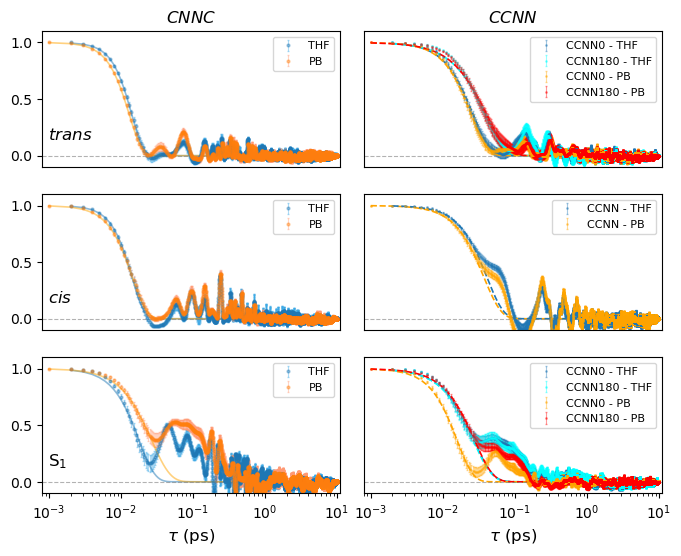

In [109]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8,6))
fig.subplots_adjust(hspace=0.2, wspace=0.08)

for j, propTOR in enumerate(["CNNC", "CCNN"]):
    ax[0, j].set_title(r"${}$".format(propTOR))
    
    for i, iso in enumerate(["trans", "cis", "s1"]):
        
        if j == 0:
            # CNNC
            torsion = "d_cnnc"
            ACORRALL = {}
            ms=1.0
            lw=1.2
            
            ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
            ACORRALL["PB"] = ACORRtotGLOB["PB"][iso]
            
            for d in ACORRALL:
                data = ACORRALL[d]["mean"].copy()
                tau = data["time"].values
                acorr = data[torsion].values
        
                std = ACORRALL[d]["std"][torsion].copy()
                ###
                info = ACORRALL[d]["info"].copy()
                prop = info[info["prop"] == torsion]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
        
                lab = d #r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)
                # print(propTOR, iso, "tau_C:", t_c, "beta:", beta, "solvent", d)
                
                ax[i, j].errorbar(tau, acorr,
                yerr=std, capsize=.5,
                color=colors[d],
                ecolor=ecolors[d], elinewidth=0.8,
                label = lab, #f"{d}" + " data",
                ls="", marker=".", ms=4., alpha=0.4)
        
                ax[i, j].plot(
                    tau, stretched_exponetial(tau, t_c, beta),
                    color=fitcolors[d],
                    lw=lw, ls="-", alpha=0.5 #, label=lab
                )
            
        elif j == 1:
            # CCNN
            iso_torsions = {
                "trans": ["d_ccnn_1", "d_ccnn_2"],
                "cis": ["d_ccnn_1", "d_ccnn_2"],
                "s1": ["d_ccnn_1", "d_ccnn_2"]
            }
            ms=1.0
            lw=1.2
            torsions = iso_torsions[iso]
            acorrTHF = ACORRtotGLOB["THF"][iso]["mean"]
            infoTHF = ACORRtotGLOB["THF"][iso]["info"]
            stdATHF = ACORRtotGLOB["THF"][iso]["std"]
        
            acorrPOL = ACORRtotGLOB["PB"][iso]["mean"]
            infoPOL = ACORRtotGLOB["PB"][iso]["info"]
            stdAPOL = ACORRtotGLOB["PB"][iso]["std"]
            
            if iso != "cis":
                ###
                prop = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = "" #r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
        
                ax[i, j].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_1"],
                    yerr=stdATHF["d_ccnn_1"], capsize=.5,
                    color="tab:blue",
                    ecolor="tab:blue", elinewidth=0.8,
                    label = "CCNN0 - THF" + lab,
                    ls="", marker=".", ms=2., alpha=0.4)

                ###
                prop = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = "" #r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
        
                ax[i, j].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_2"],
                        yerr=stdATHF["d_ccnn_2"], capsize=.5,
                        color="cyan",
                        ecolor="cyan", elinewidth=0.8,
                        label = "CCNN180 - THF" + lab,
                        ls="", marker=".", ms=2., alpha=0.4)

                ax[i, j].plot(
                    acorrTHF["time"],
                    stretched_exponetial(acorrTHF["time"], infoTHF.loc[1, "t_c"], infoTHF.loc[1, "beta"]),
                    "--",
                    color="tab:blue",
                    lw=lw
                )
                ax[i, j].plot(
                    acorrTHF["time"],
                    stretched_exponetial(acorrTHF["time"], infoTHF.loc[2, "t_c"], infoTHF.loc[2, "beta"]),
                    "--",
                    color="cyan",
                    lw=lw
                )
                
                #####################
        
                ###
                prop = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = "" #r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
            
                ax[i, j].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_1"],
                        yerr=stdAPOL["d_ccnn_1"], capsize=.5,
                        color="orange",
                        ecolor="orange", elinewidth=0.8,
                        label = "CCNN0 - PB" + lab,  # (0.0 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
                
                ###
                prop = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = "" #r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
        
                ax[i, j].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_2"],
                        yerr=stdAPOL["d_ccnn_2"], capsize=.5,
                        color="red",
                        ecolor="red", elinewidth=0.8,
                        label = "CCNN180 - PB" + lab, # (180.0 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
        
                ax[i, j].plot(
                    acorrPOL["time"],
                    stretched_exponetial(acorrPOL["time"], infoPOL.loc[1, "t_c"], infoPOL.loc[1, "beta"]),
                    "--",
                    color="orange",
                    lw=lw
                )
                ax[i, j].plot(
                    acorrPOL["time"],
                    stretched_exponetial(acorrPOL["time"], infoPOL.loc[2, "t_c"], infoPOL.loc[2, "beta"]),
                    "--",
                    color="red",
                    lw=lw
                )
        
                ######################
            
            else:
                acorrTHF["d_ccnn"] = acorrTHF["d_ccnn_1"] + acorrTHF["d_ccnn_2"]
                acorrTHF["d_ccnn"] /= 2
                
                acorrPOL["d_ccnn"] = acorrPOL["d_ccnn_1"] + acorrPOL["d_ccnn_2"]
                acorrPOL["d_ccnn"] /= 2
                
                stdATHF["d_ccnn"] = stdATHF["d_ccnn_1"] + stdATHF["d_ccnn_2"]
                stdATHF["d_ccnn"] /= 2
                
                stdAPOL["d_ccnn"] = stdAPOL["d_ccnn_1"] + stdAPOL["d_ccnn_2"]
                stdAPOL["d_ccnn"] /= 2
                
                
                ###
                prop_1 = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
                prop_2 = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
                prop = np.mean(
                        np.array([
                            prop_1.loc[:, ["t_c", "beta"]].values,
                            prop_2.loc[:, ["t_c", "beta"]].values
                        ]), axis=1)[0]
                t_c = prop[0]
                beta = prop[1]
                lab = "" #r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
                ax[i, j].errorbar(acorrTHF["time"], acorrTHF["d_ccnn"],
                        yerr=stdATHF["d_ccnn"], capsize=.5,
                        color="tab:blue",
                        ecolor="tab:blue", elinewidth=0.8,
                        label = "CCNN - THF" + lab,
                        ls="", marker=".", ms=2., alpha=0.4)
                ###
                
                a_acorr = acorrPOL["d_ccnn"][acorrPOL["time"] <= 0.03].values
                time = acorrPOL["time"][acorrPOL["time"] <= 0.03].values
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                ax[i, j].plot(
                    acorrPOL["time"],
                    stretched_exponetial(acorrPOL["time"], *popt),
                    "--",
                    color="orange",
                    lw=lw
                )
                           
                a_acorr = acorrTHF["d_ccnn"][acorrTHF["time"] <= 0.03].values
                time = acorrTHF["time"][acorrTHF["time"] <= 0.03].values
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                ax[i, j].plot(
                    acorrTHF["time"],
                    stretched_exponetial(acorrTHF["time"], *popt),
                    "--",
                    color="tab:blue",
                    lw=lw
                )
                
                ###############################
                ###
                prop_1 = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
                prop_2 = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
                prop = np.mean(
                        np.array([
                            prop_1.loc[:, ["t_c", "beta"]].values,
                            prop_2.loc[:, ["t_c", "beta"]].values
                        ]), axis=1)[0]
                t_c = prop[0]
                beta = prop[1]
                lab = "" # r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
                
                ax[i, j].errorbar(acorrPOL["time"], acorrPOL["d_ccnn"],
                        yerr=stdAPOL["d_ccnn"], capsize=.5,
                        color="orange",
                        ecolor="orange", elinewidth=0.8,
                        label = "CCNN - PB" + lab, # (103 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
                

        ##########
        ax[i, j].set_xscale("log")
        ax[i, j].set_xlabel(r"${\tau}$ (ps)")
        ax[i, j].set_xlim(.8e-3, 1.1e1)
        ax[i, j].set_ylim(-0.1, 1.1)
        ax[i, j].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
        ax[i, j].legend(fontsize=8, loc="upper right")
        
        if i != 2:
            ax[i, j].get_xaxis().set_visible(False)
            
        if j != 0:
            ax[i, j].get_yaxis().set_visible(False)
        else:
            ax[i, 0].text(
                0.02, 0.2,
                labels[iso],
                transform=ax[i, 0].transAxes,
                **textKwargs
            )

SAVEFig.saveFig("ACF_cnnc_ccnn.png")
plt.show()

CNNC trans tau_C: 0.014099566626807163 beta: 2.6784880921665555 solvent THF
CNNC trans tau_C: 0.013013802389643787 beta: 2.4283928656236893 solvent PB
CNNC cis tau_C: 0.014252824404636221 beta: 2.548787893834582 solvent THF
CNNC cis tau_C: 0.014446200297208051 beta: 2.1412265292516204 solvent PB
CNNC s1 tau_C: 0.0178809214325822 beta: 1.9657403635151582 solvent THF
CNNC s1 tau_C: 0.026702454788735636 beta: 1.675689420895096 solvent PB
line CNNC THF [0.014099566626807163, 2.6784880921665555, 0.014252824404636221, 2.548787893834582, 0.0178809214325822, 1.9657403635151582]
line CNNC PB [0.013013802389643787, 2.4283928656236893, 0.014446200297208051, 2.1412265292516204, 0.026702454788735636, 1.675689420895096]
line CCNN THF ['-', '-', 0.05346495586696947, 1.6375267699927492, '-', '-']
line CCNN PB ['-', '-', 0.04567682607720445, 1.6393874218809397, '-', '-']
line CCNN0 THF [0.02613004178728959, 1.833330409969466, '-', '-', 0.026911237415742504, 1.6333336547642352]
line CCNN0 PB [0.02470461

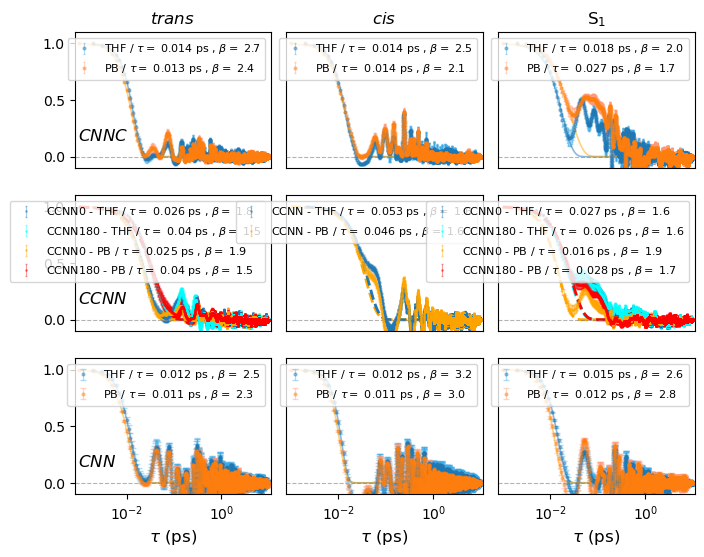

In [97]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(8,6))
fig.subplots_adjust(hspace=0.2, wspace=0.08)

ACFvals = {
    "index": [],
    "columns": [],
    "data": [],
    "index_names": ["property", "solvent"],
    "column_names": ["isomer", "parameter"]
}

lineTHF_cnnc = []
linePB_cnnc = []
lineTHF_ccnn = []
linePB_ccnn = []
lineTHF_ccnn0 = []
linePB_ccnn0 = []
lineTHF_ccnn180 = []
linePB_ccnn180 = []
lineTHF_cnn = []
linePB_cnn = []

for tor_i, sol_j in it.product(["CNNC", "CCNN", "CCNN0", "CCNN180", "CNN"], ["THF", "PB"]):
    ACFvals["index"].append((tor_i, sol_j))

for j, propTOR in enumerate(["CNNC", "CCNN", "CNN"]):
    ax[j, 0].text(
            0.02, 0.2,
            r"${}$".format(propTOR),
            transform=ax[j, 0].transAxes,
            **textKwargs
        )
    
    

    for i, iso in enumerate(["trans", "cis", "s1"]):
        ax[0, i].set_title(labels[iso])
        
        
        if j == 0:
            # CNNC
            torsion = "d_cnnc"
            ACORRALL = {}
            ms=1.0
            lw=1.0
            
            ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
            ACORRALL["PB"] = ACORRtotGLOB["PB"][iso]
            
            
            
            for d in ACORRALL:
                data = ACORRALL[d]["mean"].copy()
                tau = data["time"].values
                acorr = data[torsion].values
        
                std = ACORRALL[d]["std"][torsion].copy()
                ###
                info = ACORRALL[d]["info"].copy()
                prop = info[info["prop"] == torsion]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                if d == "THF":
                    lineTHF_cnnc.append(t_c)
                    lineTHF_cnnc.append(beta)
                elif d == "PB":
                    linePB_cnnc.append(t_c)
                    linePB_cnnc.append(beta)
                    
        
                lab = r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)
                print(propTOR, iso, "tau_C:", t_c, "beta:", beta, "solvent", d)
                
                ax[j, i].errorbar(tau, acorr,
                yerr=std, capsize=.5,
                color=colors[d],
                ecolor=ecolors[d], elinewidth=0.8,
                label = lab, #f"{d}" + " data",
                ls="", marker=".", ms=4., alpha=0.4)
        
                ax[j, i].plot(
                    tau, stretched_exponetial(tau, t_c, beta),
                    color=fitcolors[d],
                    lw=1.2, ls="-", alpha=0.5 #, label=lab
                )

            ##########
        elif j == 1:
            # CCNN
            iso_torsions = {
                "trans": ["d_ccnn_1", "d_ccnn_2"],
                "cis": ["d_ccnn_1", "d_ccnn_2"],
                "s1": ["d_ccnn_1", "d_ccnn_2"]
            }
            ms=1.0
            lw=1.0
            torsions = iso_torsions[iso]
            acorrTHF = ACORRtotGLOB["THF"][iso]["mean"]
            infoTHF = ACORRtotGLOB["THF"][iso]["info"]
            stdATHF = ACORRtotGLOB["THF"][iso]["std"]
        
            acorrPOL = ACORRtotGLOB["PB"][iso]["mean"]
            infoPOL = ACORRtotGLOB["PB"][iso]["info"]
            stdAPOL = ACORRtotGLOB["PB"][iso]["std"]
            
            if iso != "cis":
                ###
                prop = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                
                lineTHF_ccnn0.append(t_c)
                lineTHF_ccnn0.append(beta)
                if iso == "trans":
                    lineTHF_ccnn0.append("-")
                    lineTHF_ccnn0.append("-")
                
                ###
        
                ax[j, i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_1"],
                    yerr=stdATHF["d_ccnn_1"], capsize=.5,
                    color="tab:blue",
                    ecolor="tab:blue", elinewidth=0.8,
                    label = "CCNN0 - THF" + lab,
                    ls="", marker=".", ms=2., alpha=0.4)

                ###
                prop = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                
                lineTHF_ccnn180.append(t_c)
                lineTHF_ccnn180.append(beta)
                if iso == "trans":
                    lineTHF_ccnn180.append("-")
                    lineTHF_ccnn180.append("-")
                ###
        
                ax[j, i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_2"],
                        yerr=stdATHF["d_ccnn_2"], capsize=.5,
                        color="cyan",
                        ecolor="cyan", elinewidth=0.8,
                        label = "CCNN180 - THF" + lab,
                        ls="", marker=".", ms=2., alpha=0.4)

                ax[j, i].plot(acorrTHF["time"], stretched_exponetial(acorrTHF["time"], infoTHF.loc[1, "t_c"], infoTHF.loc[1, "beta"]), "--", color="tab:blue")
                ax[j, i].plot(acorrTHF["time"], stretched_exponetial(acorrTHF["time"], infoTHF.loc[2, "t_c"], infoTHF.loc[2, "beta"]), "--", color="cyan")
                
                #####################
        
                ###
                prop = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                
                linePB_ccnn0.append(t_c)
                linePB_ccnn0.append(beta)
                if iso == "trans":
                    linePB_ccnn0.append("-")
                    linePB_ccnn0.append("-")
                ###
            
                ax[j, i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_1"],
                        yerr=stdAPOL["d_ccnn_1"], capsize=.5,
                        color="orange",
                        ecolor="orange", elinewidth=0.8,
                        label = "CCNN0 - PB" + lab,  # (0.0 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
                
                ###
                prop = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                
                linePB_ccnn180.append(t_c)
                linePB_ccnn180.append(beta)
                if iso == "trans":
                    linePB_ccnn180.append("-")
                    linePB_ccnn180.append("-")
                ###
        
                ax[j, i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_2"],
                        yerr=stdAPOL["d_ccnn_2"], capsize=.5,
                        color="red",
                        ecolor="red", elinewidth=0.8,
                        label = "CCNN180 - PB" + lab, # (180.0 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
        
                ax[j, i].plot(acorrPOL["time"], stretched_exponetial(acorrPOL["time"], infoPOL.loc[1, "t_c"], infoPOL.loc[1, "beta"]), "--", color="orange")
                ax[j, i].plot(acorrPOL["time"], stretched_exponetial(acorrPOL["time"], infoPOL.loc[2, "t_c"], infoPOL.loc[2, "beta"]), "--", color="red")
        
                ######################
            
            else:
                acorrTHF["d_ccnn"] = acorrTHF["d_ccnn_1"] + acorrTHF["d_ccnn_2"]
                acorrTHF["d_ccnn"] /= 2
                
                acorrPOL["d_ccnn"] = acorrPOL["d_ccnn_1"] + acorrPOL["d_ccnn_2"]
                acorrPOL["d_ccnn"] /= 2
                
                stdATHF["d_ccnn"] = stdATHF["d_ccnn_1"] + stdATHF["d_ccnn_2"]
                stdATHF["d_ccnn"] /= 2
                
                stdAPOL["d_ccnn"] = stdAPOL["d_ccnn_1"] + stdAPOL["d_ccnn_2"]
                stdAPOL["d_ccnn"] /= 2
                
                
                ###
                prop_1 = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
                prop_2 = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
                prop = np.mean(
                        np.array([
                            prop_1.loc[:, ["t_c", "beta"]].values,
                            prop_2.loc[:, ["t_c", "beta"]].values
                        ]), axis=1)[0]
                t_c = prop[0]
                beta = prop[1]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
                ax[j, i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn"],
                        yerr=stdATHF["d_ccnn"], capsize=.5,
                        color="tab:blue",
                        ecolor="tab:blue", elinewidth=0.8,
                        label = "CCNN - THF" + lab,
                        ls="", marker=".", ms=2., alpha=0.4)
                
                lineTHF_ccnn.append("-")
                lineTHF_ccnn.append("-")
                lineTHF_ccnn.append(t_c)
                lineTHF_ccnn.append(beta)
                lineTHF_ccnn.append("-")
                lineTHF_ccnn.append("-")
                
                a_acorr = acorrPOL["d_ccnn"][acorrPOL["time"] <= 0.03].values
                time = acorrPOL["time"][acorrPOL["time"] <= 0.03].values
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                ax[j, i].plot(acorrPOL["time"], stretched_exponetial(acorrPOL["time"], *popt), "--", color="orange")
                           
                a_acorr = acorrTHF["d_ccnn"][acorrTHF["time"] <= 0.03].values
                time = acorrTHF["time"][acorrTHF["time"] <= 0.03].values
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                ax[j, i].plot(acorrTHF["time"], stretched_exponetial(acorrTHF["time"], *popt), "--", color="tab:blue")       
                
                ###############################
                ###
                prop_1 = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
                prop_2 = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
                prop = np.mean(
                        np.array([
                            prop_1.loc[:, ["t_c", "beta"]].values,
                            prop_2.loc[:, ["t_c", "beta"]].values
                        ]), axis=1)[0]
                t_c = prop[0]
                beta = prop[1]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                linePB_ccnn.append("-")
                linePB_ccnn.append("-")
                linePB_ccnn.append(t_c)
                linePB_ccnn.append(beta)
                linePB_ccnn.append("-")
                linePB_ccnn.append("-")
                ###
                
                ax[j, i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn"],
                        yerr=stdAPOL["d_ccnn"], capsize=.5,
                        color="orange",
                        ecolor="orange", elinewidth=0.8,
                        label = "CCNN - PB" + lab, # (103 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
        elif j == 2:
            iso_torsions = {
                "trans": ["a_cnn"],
                "cis": ["a_cnn"],
                "s1": ["a_cnn"]
            }
            
            ms=1.0
            lw=1.0
            torsions = iso_torsions[iso]
            ACORRALL = {}
            ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
            ACORRALL["PB"] = ACORRtotGLOB["PB"][iso]
            
            for t in torsions:
                for d in ACORRALL:
                    data = ACORRALL[d]["mean"].copy()
                    tau = data["time"].values
                    acorr = data[t].values
                
                    std = ACORRALL[d]["std"][t].copy()
                    ###
                    info = ACORRALL[d]["info"].copy()
                    prop = info[info["prop"] == t]
                    t_c = prop["t_c"].values[0]
                    beta = prop["beta"].values[0]
                    
                    if d == "THF":
                        lineTHF_cnn.append(t_c)
                        lineTHF_cnn.append(beta)
                    elif d == "PB":
                        linePB_cnn.append(t_c)
                        linePB_cnn.append(beta)
                    
                    lab = r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)
                    ax[j, i].errorbar(tau, acorr,
                        yerr=std, capsize=2.5,
                        color=colors[d],
                        ecolor=ecolors[d], elinewidth=0.9,
                        label = lab, #r"{}".format(d),
                        ls="", marker=".", ms=4., alpha=0.4)
                    ax[j, i].plot(
                        tau, stretched_exponetial(tau, t_c, beta),
                        color=fitcolors[d],
                        lw=1.2, ls="-", alpha=0.5                # label=lab
                    )
            
        ##########
        ax[j, i].set_xscale("log")
        ax[j, i].set_xlabel(r"${\tau}$ (ps)")
        ax[j, i].set_xlim(.8e-3, 1.1e1)
        ax[j, i].set_ylim(-0.1, 1.1)
        ax[j, i].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
        ax[j, i].legend(fontsize=8, loc="upper right")
        
        if j != 2:
            ax[j, i].get_xaxis().set_visible(False)
            
        if i != 0:
            ax[j, i].get_yaxis().set_visible(False)
            

for iso in ["trans", "cis", "s1"]:
    ACFvals["columns"].append((iso, r"$\tau\_c$"))
    ACFvals["columns"].append((iso, r"$\beta$"))
    
print("line CNNC THF", lineTHF_cnnc)
print("line CNNC PB", linePB_cnnc)
print("line CCNN THF", lineTHF_ccnn)
print("line CCNN PB", linePB_ccnn)
print("line CCNN0 THF", lineTHF_ccnn0)
print("line CCNN0 PB", linePB_ccnn0)
print("line CCNN180 THF", lineTHF_ccnn180)
print("line CCNN180 PB", linePB_ccnn180)
print("line CNN THF", lineTHF_cnn)
print("line CNN PB", linePB_cnn)
# SAVEFig.saveFig("ACF_all.png")
plt.show()

Auto-correlation function observed for different properties and compared for each isomer in PB and THF

In [98]:
data = [
    lineTHF_cnnc,
    linePB_cnnc,
    lineTHF_ccnn,
    linePB_ccnn,
    lineTHF_ccnn0,
    linePB_ccnn0,
    lineTHF_ccnn180,
    linePB_ccnn180,
    lineTHF_cnn,
    linePB_cnn
]

In [100]:
ACFvals["data"] = data # [] # np.ones((6,2))

In [102]:
ACFvals["data"] = data
# ACFvals

In [103]:
acfTAB = pd.DataFrame.from_dict(ACFvals, orient='tight')

In [104]:
acfTAB.style.format(precision=3)

In [105]:
acfTAB.style.format(precision=3).to_latex(
    "acfTab_new.tex",
    label="tab:acf",
    caption="Characteristic time values calculated from the ACF curves."
)

Image 17 saved!
/home/ovillegas/figures/figPapers/img_0017_ACF_cnnc_ccnn.png


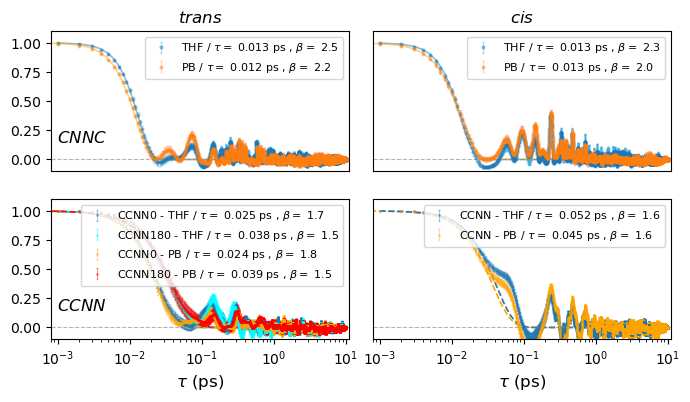

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,4))
fig.subplots_adjust(hspace=0.2, wspace=0.08)

for j, propTOR in enumerate(["CNNC", "CCNN"]):
    ax[j, 0].text(
            0.02, 0.2,
            r"${}$".format(propTOR),
            transform=ax[j, 0].transAxes,
            **textKwargs
        )
    
    

    for i, iso in enumerate(["trans", "cis"]):
        ax[0, i].set_title(labels[iso])
        
        
        if j == 0:
            # CNNC
            torsion = "d_cnnc"
            ACORRALL = {}
            ms=1.0
            lw=1.2
            
            ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
            ACORRALL["PB"] = ACORRtotGLOB["PB"][iso]
            
            
            
            for d in ACORRALL:
                data = ACORRALL[d]["mean"].copy()
                tau = data["time"].values
                acorr = data[torsion].values
        
                std = ACORRALL[d]["std"][torsion].copy()
                ###
                info = ACORRALL[d]["info"].copy()
                prop = info[info["prop"] == torsion]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
        
                lab = r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)
                # print(propTOR, iso, "tau_C:", t_c, "beta:", beta, "solvent", d)
                
                ax[j, i].errorbar(tau, acorr,
                yerr=std, capsize=.5,
                color=colors[d],
                ecolor=ecolors[d], elinewidth=0.8,
                label = lab, #f"{d}" + " data",
                ls="", marker=".", ms=4., alpha=0.4)
        
                ax[j, i].plot(
                    tau, stretched_exponetial(tau, t_c, beta),
                    color=fitcolors[d],
                    lw=lw, ls="-", alpha=0.5 #, label=lab
                )

            ##########
        elif j == 1:
            # CCNN
            iso_torsions = {
                "trans": ["d_ccnn_1", "d_ccnn_2"],
                "cis": ["d_ccnn_1", "d_ccnn_2"],
                "s1": ["d_ccnn_1", "d_ccnn_2"]
            }
            ms=1.0
            lw=1.2
            torsions = iso_torsions[iso]
            acorrTHF = ACORRtotGLOB["THF"][iso]["mean"]
            infoTHF = ACORRtotGLOB["THF"][iso]["info"]
            stdATHF = ACORRtotGLOB["THF"][iso]["std"]
        
            acorrPOL = ACORRtotGLOB["PB"][iso]["mean"]
            infoPOL = ACORRtotGLOB["PB"][iso]["info"]
            stdAPOL = ACORRtotGLOB["PB"][iso]["std"]
            
            if iso != "cis":
                ###
                prop = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
        
                ax[j, i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_1"],
                    yerr=stdATHF["d_ccnn_1"], capsize=.5,
                    color="tab:blue",
                    ecolor="tab:blue", elinewidth=0.8,
                    label = "CCNN0 - THF" + lab,
                    ls="", marker=".", ms=2., alpha=0.4)

                ###
                prop = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
        
                ax[j, i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn_2"],
                        yerr=stdATHF["d_ccnn_2"], capsize=.5,
                        color="cyan",
                        ecolor="cyan", elinewidth=0.8,
                        label = "CCNN180 - THF" + lab,
                        ls="", marker=".", ms=2., alpha=0.4)

                ax[j, i].plot(
                    acorrTHF["time"],
                    stretched_exponetial(acorrTHF["time"], infoTHF.loc[1, "t_c"], infoTHF.loc[1, "beta"]),
                    "--",
                    color="tab:blue",
                    lw=lw
                )
                ax[j, i].plot(
                    acorrTHF["time"],
                    stretched_exponetial(acorrTHF["time"], infoTHF.loc[2, "t_c"], infoTHF.loc[2, "beta"]),
                    "--",
                    color="cyan",
                    lw=lw
                )
                
                #####################
        
                ###
                prop = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
            
                ax[j, i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_1"],
                        yerr=stdAPOL["d_ccnn_1"], capsize=.5,
                        color="orange",
                        ecolor="orange", elinewidth=0.8,
                        label = "CCNN0 - PB" + lab,  # (0.0 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
                
                ###
                prop = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
        
                ax[j, i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn_2"],
                        yerr=stdAPOL["d_ccnn_2"], capsize=.5,
                        color="red",
                        ecolor="red", elinewidth=0.8,
                        label = "CCNN180 - PB" + lab, # (180.0 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
        
                ax[j, i].plot(
                    acorrPOL["time"],
                    stretched_exponetial(acorrPOL["time"], infoPOL.loc[1, "t_c"], infoPOL.loc[1, "beta"]),
                    "--",
                    color="orange",
                    lw=lw
                )
                ax[j, i].plot(
                    acorrPOL["time"],
                    stretched_exponetial(acorrPOL["time"], infoPOL.loc[2, "t_c"], infoPOL.loc[2, "beta"]),
                    "--",
                    color="red",
                    lw=lw
                )
        
                ######################
            
            else:
                acorrTHF["d_ccnn"] = acorrTHF["d_ccnn_1"] + acorrTHF["d_ccnn_2"]
                acorrTHF["d_ccnn"] /= 2
                
                acorrPOL["d_ccnn"] = acorrPOL["d_ccnn_1"] + acorrPOL["d_ccnn_2"]
                acorrPOL["d_ccnn"] /= 2
                
                stdATHF["d_ccnn"] = stdATHF["d_ccnn_1"] + stdATHF["d_ccnn_2"]
                stdATHF["d_ccnn"] /= 2
                
                stdAPOL["d_ccnn"] = stdAPOL["d_ccnn_1"] + stdAPOL["d_ccnn_2"]
                stdAPOL["d_ccnn"] /= 2
                
                
                ###
                prop_1 = infoTHF[infoTHF["prop"] == "d_ccnn_1"]
                prop_2 = infoTHF[infoTHF["prop"] == "d_ccnn_2"]
                prop = np.mean(
                        np.array([
                            prop_1.loc[:, ["t_c", "beta"]].values,
                            prop_2.loc[:, ["t_c", "beta"]].values
                        ]), axis=1)[0]
                t_c = prop[0]
                beta = prop[1]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
                ax[j, i].errorbar(acorrTHF["time"], acorrTHF["d_ccnn"],
                        yerr=stdATHF["d_ccnn"], capsize=.5,
                        color="tab:blue",
                        ecolor="tab:blue", elinewidth=0.8,
                        label = "CCNN - THF" + lab,
                        ls="", marker=".", ms=2., alpha=0.4)
                ###
                
                a_acorr = acorrPOL["d_ccnn"][acorrPOL["time"] <= 0.03].values
                time = acorrPOL["time"][acorrPOL["time"] <= 0.03].values
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                ax[j, i].plot(
                    acorrPOL["time"],
                    stretched_exponetial(acorrPOL["time"], *popt),
                    "--",
                    color="orange",
                    lw=lw
                )
                           
                a_acorr = acorrTHF["d_ccnn"][acorrTHF["time"] <= 0.03].values
                time = acorrTHF["time"][acorrTHF["time"] <= 0.03].values
                popt, pcov = curve_fit(
                    stretched_exponetial,
                    time,
                    a_acorr,
                    bounds=([0.0, 1.5], [0.15, 8.])
                )
                info = {"prop":a, "t_c": popt[0], "beta": popt[1], "isomer": iso, "system": system}
                ax[j, i].plot(
                    acorrTHF["time"],
                    stretched_exponetial(acorrTHF["time"], *popt),
                    "--",
                    color="tab:blue",
                    lw=lw
                )
                
                ###############################
                ###
                prop_1 = infoPOL[infoPOL["prop"] == "d_ccnn_1"]
                prop_2 = infoPOL[infoPOL["prop"] == "d_ccnn_2"]
                prop = np.mean(
                        np.array([
                            prop_1.loc[:, ["t_c", "beta"]].values,
                            prop_2.loc[:, ["t_c", "beta"]].values
                        ]), axis=1)[0]
                t_c = prop[0]
                beta = prop[1]
                lab = r" / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(t_c, beta)
                ###
                
                ax[j, i].errorbar(acorrPOL["time"], acorrPOL["d_ccnn"],
                        yerr=stdAPOL["d_ccnn"], capsize=.5,
                        color="orange",
                        ecolor="orange", elinewidth=0.8,
                        label = "CCNN - PB" + lab, # (103 deg)
                        ls="", marker=".", ms=2., alpha=0.4)
            
        ##########
        ax[j, i].set_xscale("log")
        ax[j, i].set_xlabel(r"${\tau}$ (ps)")
        ax[j, i].set_xlim(.8e-3, 1.1e1)
        ax[j, i].set_ylim(-0.1, 1.1)
        ax[j, i].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
        ax[j, i].legend(fontsize=8, loc="upper right")
        
        if j != 1:
            ax[j, i].get_xaxis().set_visible(False)
            
        if i != 0:
            ax[j, i].get_yaxis().set_visible(False)

SAVEFig.saveFig("ACF_cnnc_ccnn.png")
plt.show()

In [40]:
SAVEFig.set_count(16)
SAVEFig.showInfo()

Output folder: /home/ovillegas/figures/figPapers
Count: 16


Image 18 saved!
/home/ovillegas/figures/figPapers/img_0018_ACF_cnn.png


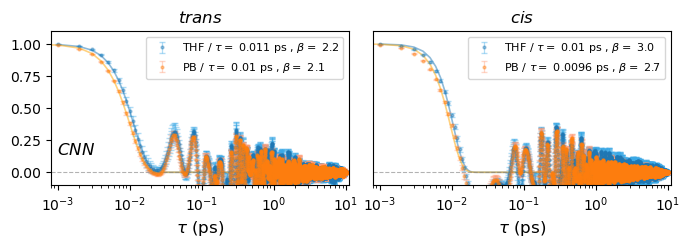

In [23]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.08)

for j, propTOR in enumerate(["CNN"]):
    ax[0].text(
            0.02, 0.2,
            r"${}$".format(propTOR),
            transform=ax[0].transAxes,
            **textKwargs
        )
    
    

    for i, iso in enumerate(["trans", "cis"]):
        ax[i].set_title(labels[iso])
        
        
        iso_torsions = {
            "trans": ["a_cnn"],
            "cis": ["a_cnn"],
            "s1": ["a_cnn"]
        }
        ms=1.0
        lw=1.2
        torsions = iso_torsions[iso]
        ACORRALL = {}
        ACORRALL["THF"] = ACORRtotGLOB["THF"][iso]
        ACORRALL["PB"] = ACORRtotGLOB["PB"][iso]
        
        for t in torsions:
            for d in ACORRALL:
                data = ACORRALL[d]["mean"].copy()
                tau = data["time"].values
                acorr = data[t].values
            
                std = ACORRALL[d]["std"][t].copy()
                ###
                info = ACORRALL[d]["info"].copy()
                prop = info[info["prop"] == t]
                t_c = prop["t_c"].values[0]
                beta = prop["beta"].values[0]
                ###
                
                lab = r"{} / $\tau=$ {:.2} ps , $\beta=$ {:.2}".format(d, t_c, beta)
                ax[i].errorbar(tau, acorr,
                    yerr=std, capsize=2.5,
                    color=colors[d],
                    ecolor=ecolors[d], elinewidth=0.9,
                    label = lab, #r"{}".format(d),
                    ls="", marker=".", ms=4., alpha=0.4)
                
                ax[i].plot(
                    tau, stretched_exponetial(tau, t_c, beta),
                    color=fitcolors[d],
                    lw=lw, ls="-", alpha=0.5                # label=lab
                )
            
        ##########
        ax[i].set_xscale("log")
        ax[i].set_xlabel(r"${\tau}$ (ps)")
        ax[i].set_xlim(.8e-3, 1.1e1)
        ax[i].set_ylim(-0.1, 1.1)
        ax[i].axhline(y=0.0, color="gray", ls="--", lw=0.8, alpha=0.6)
        ax[i].legend(fontsize=8, loc="upper right")
            
        if i != 0:
            ax[i].get_yaxis().set_visible(False)

SAVEFig.saveFig("ACF_cnn.png")
plt.show()

### Mean square displacement

#### MSD center of mass

In [12]:
isomers = ["trans", "cis"]
systems = ["THF", "PB", "PB-OH"]
replicas = ["0", "1", "2", "3", "4"]
MSDALLcm = {}
CHECK = []

for iso in isomers:
    MSDALLcm[iso] = {}
    for sol in systems:
        MSDALLcm[iso][sol] = {}
        for r in replicas:
            MSDALLcm[iso][sol][r] = {}
            if sol == "PB":
                File_short = "../exp.azob.stamp.5/{}/6_prod_{}/msd_cm.csv".format(iso, r)
                File = "../exp.azob.stamp.3/{}/6_prod_{}/msd_cm.csv".format(iso, r)
            elif sol == "PB-OH":
                File_short = "../exp.azob.stamp.5/{}/9_prod_OH_{}/msd_cm.csv".format(iso, r)
                File = "../exp.azob.stamp.3/{}/9_prod_OH_{}/msd_cm.csv".format(iso, r)
            elif sol == "THF":
                File_short = "../exp.azob.gmx/{}.thf/{}/md_10ps/msd_cm.csv".format(iso, r)
                File = "../exp.azob.gmx/{}.thf/{}/md/msd_cm.csv".format(iso, r)
            
            ##print("Files:")
            ##print(File_short)
            ##print(File)
            data_short = pd.DataFrame()
            data = pd.DataFrame()
            
            try:
                data_short = pd.read_csv(File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File_short)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "short",
                    "Done": "x"
                })
                
            try:
                data = pd.read_csv(File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": ""
                })
            except FileNotFoundError:
                print("#" * 40)
                print("\tError, file not founded:\n", File)
                CHECK.append({
                    "isomer": iso,
                    "system": sol,
                    "replica": r,
                    "type": "long",
                    "Done": "x"
                })
                
            try:
                data_short = data_short[data_short["time"] <= 2.5]
                data_short["msd"][data_short["time"]==0.0] = 0.0
                data_short.drop(data_short[data_short['time'] == 0.0].index, inplace = True)
                # print(data_short)
            except KeyError:
                pass
                
            try:
                data = data[data["time"] <= 1000.]
                data["msd"][data["time"]==0.0] = 0.0
                data.drop(data[data['time'] <= 2.0].index, inplace = True)
                # print(data)
            except KeyError:
                pass
            
            # data.drop(data[data[''] >= 24000].index, inplace = True)
            

            MSDALLcm[iso][sol][r]["data"] = pd.concat(
                [data_short, data],
                ignore_index=True
            )
            short_log2 = get_log2_av(data_short)
            data_log2 = get_log2_av(data)
            MSDALLcm[iso][sol][r]["logAv"] = pd.concat(
                [short_log2, data_log2], # [short_log2[short_log2["logAv_tau"] <= 1.0], data_log2],
                ignore_index=True
            )
            
            
            # MSDALLcm[iso][sol][r] = data

            
CHECK = pd.DataFrame(CHECK)
CHECK[CHECK["Done"] == "x"].style.format(subset=["Done"]).apply(nbconfig.isNotMSD, color="red")

,isomer,system,replica,type,Done


In [13]:
MSDMeanscm = {}

for iso in MSDALLcm:
    MSDMeanscm[iso] = {}
    for sol in MSDALLcm[iso]:
        df_concat = []
        df_log2Mean = []
        MSDMeanscm[iso][sol] = {}
        for r in MSDALLcm[iso][sol]:
            df_concat.append(MSDALLcm[iso][sol][r]["data"])
            df_log2Mean.append(MSDALLcm[iso][sol][r]["logAv"])
            
        df_concat = pd.concat(tuple(df_concat))    
        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        
        df_std = by_row_index.std()
        df_std /= np.sqrt(5)
        
        # dflogAv = get_log2_av(df_means)
        
        df_log2Mean = pd.concat(tuple(df_log2Mean))
        by_row_index = df_log2Mean.groupby(df_log2Mean.index)
        df_log2Mean = by_row_index.mean()
        
        try:
            MSDMeanscm[iso][sol]["mean"] = df_means.sort_values(by=["time"])
            MSDMeanscm[iso][sol]["std"] = df_std.sort_values(by=["time"])
            MSDMeanscm[iso][sol]["logAv"] = df_log2Mean
            MSDMeanscm[iso][sol]["diff"] = nbconfig.get_diff(
                df_log2Mean["logAv_tau"], df_log2Mean["logAv_msd"]
            )
        except KeyError:
            continue

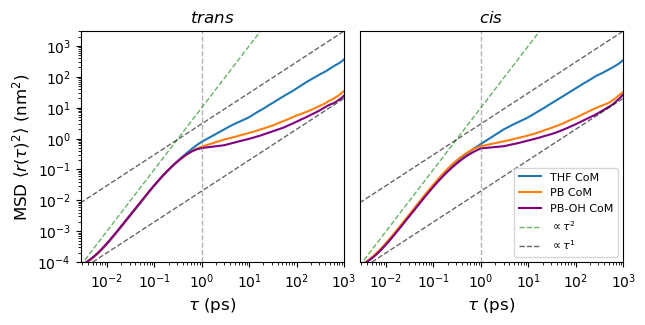

In [141]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7,3))
fig.subplots_adjust(hspace=0., wspace=0.06)

for i, iso in enumerate(MSDMeanscm):
    ax[i].set_title(labels[iso])

    for sol in MSDMeanscm[iso]:
        msd = MSDMeanscm[iso][sol]["mean"]
        ax[i].plot(
            msd["time"], msd["msd"],
            "-", lw=1.5, ms=1., label=sol + " CoM", color=colors[sol])
        
        
        if sol == "PB-OH":
            ax[i].plot(msd["time"], 10*msd["time"]**2, "--", lw=1., color="green", label=r"$\propto\tau^2$", alpha=0.6)
            ax[i].plot(msd["time"], 3*msd["time"], "--", lw=1., color="k", label=r"$\propto\tau^1$", alpha=0.6)
            ax[i].plot(msd["time"], 0.02*msd["time"], "--", lw=1., color="k", alpha=0.6)
        
            ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)

        
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    ax[i].set_xlim(2.8e-3, 1.e3)
    ax[i].set_ylim(1.0e-4, 3.0e3)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    if i != 0:
        # ax[i, j].set_yticks([])
        ax[i].get_yaxis().set_visible(False)
        
ax[1].legend(fontsize=8, loc="lower right")
ax[0].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle$ (nm$^2$)")

# SAVEFig.saveFig("MSD_cm_all.png")
plt.show()

Comparison of the MSD obtained for center of masses

Image 3 saved!
/home/ovillegas/figures/figPapers/img_0003_MSD_alpha_comparison_allatoms.png


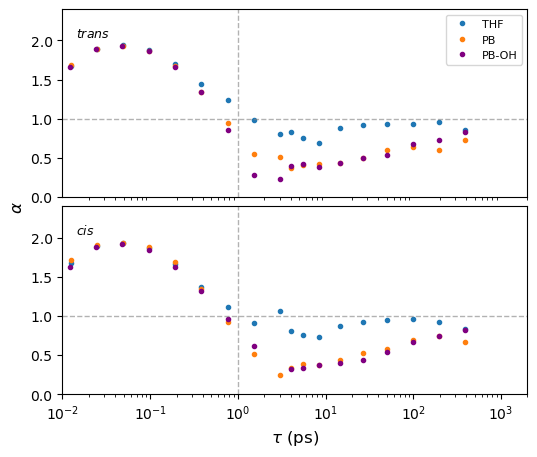

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(6, 5))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i, iso in enumerate(MSDMeanscm):
    for sol in MSDMeanscm[iso]:
        alpha = MSDMeanscm[iso][sol]["diff"]
        # print(alpha)
        
        ax[i].plot(
           alpha["tau"], alpha["alpha"],
            ".", lw=2., ms=6., label=sol, color=colors[sol]
        )
        
    ax[i].axhline(y=1., lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].text(
            0.03, 0.85,
            "{}".format(labels[iso]), transform=ax[i].transAxes,
            ha="left",
            rotation=0, fontsize=9
        )

        
    ax[i].set_xscale("log")
    ax[i].set_xlim(1e-2, 2.0e3)
    ax[i].set_ylim(0.0, 2.4)
    # ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    # ax[i].axvline(x=5e2, lw=1.0, ls="--", color="gray", alpha=0.6) # hacer el promedio >=
    ax[i].set_xlabel(r"$\tau$ (ps)")
    ##
    if i == 0:
        ax[i].set_xticks([])
    ##    ax[i].get_yaxis().set_visible(False)

ax[0].legend(fontsize=8, loc="upper right")
ax[1].set_ylabel(r"$\alpha$", y=1.0)

SAVEFig.saveFig("MSD_alpha_comparison_allatoms.png")
plt.show()

Image 7 saved!
/home/ovillegas/figures/figPapers/img_0007_Diffusiv_cm_all.png


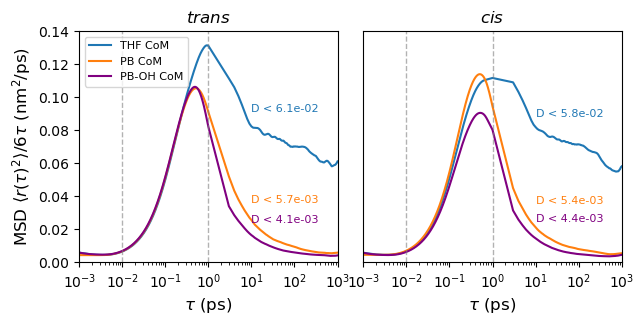

In [252]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7,3))
fig.subplots_adjust(hspace=0., wspace=0.1)

for i, iso in enumerate(MSDMeanscm):
    ax[i].set_title(labels[iso])
    for sol in MSDMeanscm[iso]:
        msd = MSDMeanscm[iso][sol]
        ax[i].plot(
            msd["time"], msd["msd"]/(6*msd["time"]),
            "-", lw=1.5, ms=1., label=sol + " CoM", color=colors[sol])
        
        msdDcoef = msd.tail(10)["msd"]/(6 * msd.tail(10)["time"])
        move = 0.02
        if sol == "THF":
            move = 0.03
        elif sol == "PB":
            move = 0.03
        ax[i].text(
            10, msdDcoef.mean() + move,
            "D < %.1e" % msdDcoef.mean(),
            ha="left", fontsize=8, color=colors[sol]
        )
        
    ax[i].set_xscale("log")
    ax[i].set_xlim(1.e-3, 1.e3)
    ax[i].set_ylim(0.0, 0.14)
    ax[i].axvline(x=1e-2, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].axvline(x=1e0, lw=1.0, ls="--", color="gray", alpha=0.6)
    ax[i].set_xlabel(r"$\tau$ (ps)")
    
    if i != 0:
        # ax[i, j].set_yticks([])
        ax[i].get_yaxis().set_visible(False)

ax[0].legend(fontsize=8, loc="upper left")
ax[0].set_ylabel(r"MSD $\langle{r(\tau)^2}\rangle/6\tau$ (nm$^2$/ps)")

SAVEFig.saveFig("Diffusiv_cm_all.png")
plt.show()       

Variation of center of mass diffusivity as a function of time.

### TD-DFT sampling analysis

In [9]:
%%time

isomers = ["trans", "cis"]
solvents = ["THF", "PB"]
# replicas = ["0", "1", "2", "3", "4"]
UVVisG = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVisG[iso] = {}
    for sol in solvents:
        UVVisG[iso][sol] = {}
        dtype = "cont"
        print(iso, sol)
        path = ""
        if sol == "THF":
            path = f"{home_gro}/{iso}.thf/*/md/SamplingUV-Vis_0_2000/*.log"
        elif sol == "PB":
            path = f"{home_stamp}/{iso}/6_prod_*/SamplingUV-Vis_500_2500/*.log"
            
        if "THF" in sol:
            dtype = "GMX"

        spectre, info = nbconfig.get_spectre_info(
            glob.glob(path),
            dtype=dtype,
            sigma=sigma
        )
            
            
        ## info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
        # info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
        # info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
        
        #except KeyError:
        #    print(info)
        #    print(geom)
        #    raise KeyError
        # print(info)
        
        UVVisG[iso][sol]["spectre"] = spectre
        UVVisG[iso][sol]["info"] = info
        
        if sol == "THF":
            path = f"{home_gro}/{iso}.thf/*/md/SamplingUV-Vis_0_2000_notSolvent/*.log"
            
        
        elif sol == "PB":
            path = f"{home_stamp}/{iso}/6_prod_*/SamplingUV-Vis_notSolvent/*.log"
        
        spectre, info = nbconfig.get_spectre_info(
            glob.glob(path),
            dtype=dtype,
            sigma=sigma
        )
    
        UVVisG[iso][f"{sol}-Vac"] = {}
        UVVisG[iso][f"{sol}-Vac"]["spectre"] = spectre
        UVVisG[iso][f"{sol}-Vac"]["info"] = info

trans THF
Number of files analyzed: 500
Number of files analyzed: 500
trans PB
Number of files analyzed: 500
Number of files analyzed: 500
cis THF
Number of files analyzed: 500
Number of files analyzed: 500
cis PB
Number of files analyzed: 500
Number of files analyzed: 500
CPU times: user 47.9 s, sys: 279 ms, total: 48.2 s
Wall time: 48.4 s


In [10]:
%%time

isomers = ["trans", "cis"]
solvents = ["PBOH-Vac", "PBOH-Eps1"]
# replicas = ["0", "1", "2", "3", "4"]
UVVisG_OH = {}
sigma = 0.3
dtype = "cont"


for iso in isomers:
    UVVisG_OH[iso] = {}
    for sol in solvents:
        UVVisG_OH[iso][sol] = {}
        dtype = "cont"
        print(iso, sol)
        
        path = ""
        if sol == "PBOH-Vac":
            path = f"{home_stamp}/{iso}/9_prod_*/SamplingUV-Vis_0_2000/*.log"
        elif sol == "PBOH-Eps1":
            path = f"{home_stamp}/{iso}/9_prod_*/SamplingUV-Vis_0_2000_epsilon1/*.log"

        spectre, info = nbconfig.get_spectre_info(
            glob.glob(path),
            dtype=dtype,
            sigma=sigma
        )
            
            
        ## info["d_cnnc"] = get_geom_properties(info, geom, "d_cnnc")
        # info["a_coh"] = get_geom_properties(info, geom, "a_coh_1")
        # info["r_oh"] = get_geom_properties(info, geom, "r_oh_1")
    
        UVVisG_OH[iso][sol]["spectre"] = spectre
        UVVisG_OH[iso][sol]["info"] = info

trans PBOH-Vac
Number of files analyzed: 500
trans PBOH-Eps1
ERROR in file: /home/ovillegas/exp.azob.stamp.3/trans/9_prod_OH_0/SamplingUV-Vis_0_2000_epsilon1/azoT__00414.log
ERROR in file: /home/ovillegas/exp.azob.stamp.3/trans/9_prod_OH_1/SamplingUV-Vis_0_2000_epsilon1/azoT__00833.log
ERROR in file: /home/ovillegas/exp.azob.stamp.3/trans/9_prod_OH_2/SamplingUV-Vis_0_2000_epsilon1/azoT__00794.log
ERROR in file: /home/ovillegas/exp.azob.stamp.3/trans/9_prod_OH_3/SamplingUV-Vis_0_2000_epsilon1/azoT__00716.log
ERROR in file: /home/ovillegas/exp.azob.stamp.3/trans/9_prod_OH_4/SamplingUV-Vis_0_2000_epsilon1/azoT__00737.log
Number of files analyzed: 191
cis PBOH-Vac
Number of files analyzed: 500
cis PBOH-Eps1
ERROR in file: /home/ovillegas/exp.azob.stamp.3/cis/9_prod_OH_0/SamplingUV-Vis_0_2000_epsilon1/azoC__00323.log
ERROR in file: /home/ovillegas/exp.azob.stamp.3/cis/9_prod_OH_1/SamplingUV-Vis_0_2000_epsilon1/azoC__00701.log
ERROR in file: /home/ovillegas/exp.azob.stamp.3/cis/9_prod_OH_2/S

In [11]:
# Experimental data
trans_exp = pd.read_csv("UV-cis.csv", header=None, names=["wl", "abs", "2", "3"])
cis_exp = pd.read_csv("UV-trans.csv", header=None, names=["wl", "abs", "2", "3"])

cis_exp["abs"] = cis_exp["abs"]/cis_exp["abs"][cis_exp["wl"] > 300].max()
trans_exp["abs"] = trans_exp["abs"]/trans_exp["abs"][trans_exp["wl"] > 300].max()

experiments = {
    "trans": trans_exp,
    "cis": cis_exp
}

w_nm = nbconfig.w_nm

In [64]:
UVVisG["trans"]["PB-OH"] = UVVisG_OH["trans"]["PBOH-Eps1"].copy()

Image 8 saved!
/home/ovillegas/figures/figPapers/img_0008_UVVis_spectres.png


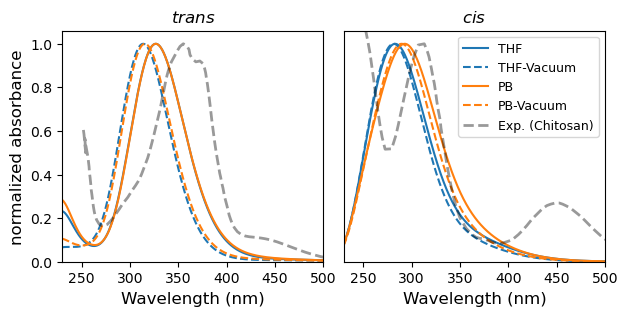

In [272]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(7,3))
fig.subplots_adjust(wspace=0.08)

# fig.suptitle("Using SCRF", y=0.93)
w_nm = nbconfig.w_nm

for i, iso in enumerate(UVVisG):
    ax[i].set_title(labels[iso])
    
    # ax[i].text(
    #         0.02, 0.85,
    #         labels[iso],
    #         transform=ax[i].transAxes, ha="left", rotation=0, fontsize=14
    #     )
    
    for sol in UVVisG[iso]:
        ls = "-"
        if "Vac" in sol:
            ls = "--"
        
        
        absorb = UVVisG[iso][sol]["spectre"].copy()
        # print(sol.split("-")[0])
                
        ax[i].plot(
            w_nm,
            absorb/absorb.max(),
            label=sol.replace("Vac", "Vacuum"),
            ls=ls, lw=1.5,
            color=colors[sol.split("-")[0]])
        
    dexp = experiments[iso].copy()
    
    ax[i].plot(
        dexp["wl"], dexp["abs"],
        color="k",
        alpha=0.4,
        ls="--",
        lw=2.0,
        label="Exp. (Chitosan)"
    )
    
    # ax[i, j].title("Isomer cis")
    ax[i].set_ylabel("normalized absorbance", fontsize=12)
    ax[i].set_xlabel("Wavelength (nm)", fontsize=12)
    ax[i].set_xlim(230, 500)
    ax[i].set_ylim(0, 1.06)
    
    if i == 1:
        # ax[i, j].set_yticks([])
        ax[i].get_yaxis().set_visible(False)
        ax[i].legend(fontsize=9)
    
# saveFig("UVVis-spectres_news.png")
SAVEFig.saveFig("UVVis_spectres.png")
plt.show()

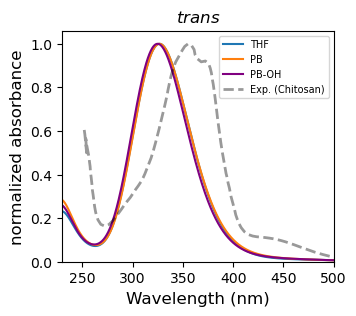

In [65]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.5,3))
fig.subplots_adjust(wspace=0.08)

# fig.suptitle("Using SCRF", y=0.93)
w_nm = nbconfig.w_nm

# table
table = {"wavelength": w_nm}

iso="trans"
ax.set_title(labels[iso])
    
for sol in UVVisG[iso]:
    ls = "-"
    if "Vac" in sol:
        continue
    
    
    absorb = UVVisG[iso][sol]["spectre"].copy()
    # print(sol.split("-")[0])
            
    ax.plot(
        w_nm,
        absorb/absorb.max(),
        label=sol.replace("Vac", "Vacuum"),
        ls=ls, lw=1.5,
        color=colors[sol])
    
    table[sol] = absorb/absorb.max()
    
dexp = experiments[iso].copy()

ax.plot(
    dexp["wl"], dexp["abs"],
    color="k",
    alpha=0.4,
    ls="--",
    lw=2.0,
    label="Exp. (Chitosan)"
)

# ax[i, j].title("Isomer cis")
ax.set_ylabel("normalized absorbance", fontsize=12)
ax.set_xlabel("Wavelength (nm)", fontsize=12)
ax.set_xlim(230, 500)
ax.set_ylim(0, 1.06)

ax.legend(fontsize=7)
    
saveFig("UVVis-spectres_trans.png")
# SAVEFig.saveFig("UVVis_spectres.png")
plt.show()

In [66]:
table = pd.DataFrame(table)
table.to_csv(f"{send_to_aurelie}/data_UVVis_trans_PB_THF.csv", float_format="%.6f", index=False)

In [42]:
dexp

,wl,abs,2,3
0,251.739447,0.604682,-1,
1,252.362171,0.583726,-1,
2,254.115379,0.499341,-1,
3,253.296257,0.564369,-1,
4,254.603978,0.524943,-1,
...,...,...,...,...
143,569.110793,0.004953,-1,
144,573.911996,0.005424,-1,
145,577.797795,0.005147,-1,
146,587.138657,0.005965,-1,


In [43]:
dexp["wavelength"] = dexp["wl"]

In [47]:
dexp.loc[:, ["wavelength", "abs"]].to_csv(f"{send_to_aurelie}/data_UVVis_trans_exp.csv", float_format="%.6f", index=False)

### Cohesion energy

In [19]:
%%time
CED = {}
for iso in ["trans", "cis", "s1"]:
    print("ISOMER:", iso)
    CED[iso] = {}
    DATA = []
    for r in ["0", "1", "2", "3", "4"]:
        print("replica:", r)
        donnees = f"../exp.azob.stamp.3/{iso}/6_prod_{r}/DONNEES.in"
        if iso=="s1":
            system = STAMP(donnees, traj_type="XTC")
            system.get_traj()
        else:
            system = STAMP(donnees, traj_type="GRO")
        print(donnees)
        
        # Data
        data = system.data.copy()
        
        # N atoms
        natoms = system.Natoms
        
        # Volume (nm3)
        vol = system.vol[-1]
        # nm3 --> m3
        vol *= 1e-27
        
        data["ced"] = -(data["Epot_inter"] / N_A / 1e-3) * natoms / vol
        data["delta"] = np.sqrt(data["ced"] * 1e-6)
        data["replica"] = r
        data["isomer"] = iso
        DATA.append(data)
    CED[iso] = pd.concat(DATA, ignore_index=True)
    
# Polymer PB
print("Polymer")
donnees = f"../exp.azob.stamp.3/polymer/6_prod/DONNEES.in"
system = STAMP(donnees, traj_type="GRO")
print(donnees)
    
# Data
data = system.data.copy()
   
# N atoms
natoms = system.Natoms
    
# Volume (nm3)
vol = system.vol[-1]
# nm3 --> m3
vol *= 1e-27
   
data["ced"] = -(data["Epot_inter"] / N_A / 1e-3) * natoms / vol
data["delta"] = np.sqrt(data["ced"] * 1e-6)
data["replica"] = "0"
data["isomer"] = "PB"
CED["PB"] = data.copy()
        

ISOMER: trans
replica: 0
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 5.010e-10
Initial frame: 2000000
Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.99 s
Number of frames 2000
../exp.azob.stamp.3/trans/6_prod_0/DONNEES.in
replica: 1
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 5.010e-10
Initial frame: 2000000
Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.98 s
Number of frames 2000
../exp.azob.stamp.3/trans/6_prod_1/DONNEES.in
replica: 2
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 5.010e-10
Initial frame: 2000000
Reading fatomes file - done in 0.13 s
Searching connectivity - done in 3.11 s
Number of frames 2000
../exp.azob.stamp.3/trans/6_prod_2/DONNEES.in
replica: 3
Reading log file - time step detected (ps): 0.00025
Initial time detected (ps): 5.010e-10
Initial frame: 2000000
Reading fatomes file - done in 0.14 s
Searching conn

In [23]:
labels = {
    "trans":"$trans$",
    "cis":r"$cis$",
    "s1":"S$_1$",
    "PB": "polymer"
}

'        \n    ax[i].legend()\n    ax[i].set_ylabel(r"CED [$-E_{inter} \times Natomes / volume$] (J/m$^3$)")\n    \n    ax[i].grid(True, linestyle=\'--\', linewidth=0.5, color=\'gray\', alpha=0.6)\n    \n    # ax[i].set_ylim(-3.15e8, -2.8e8)\n    ax[i].set_ylim(2.70e8, 3.2e8)\n    ax[i].set_xlim(0, 1700)\n    ax[i].set_xlabel("time (ps)")\n    \n    ax[i].axvline(x=800, ls="--", lw=1., color="k")\n    \n    if i != 0:\n        ax[i].set_yticklabels([])\n        ax[i].set_ylabel("")\n\nsave_fig("ced_in_time.png", "../figures/")\n\nplt.show()\n'

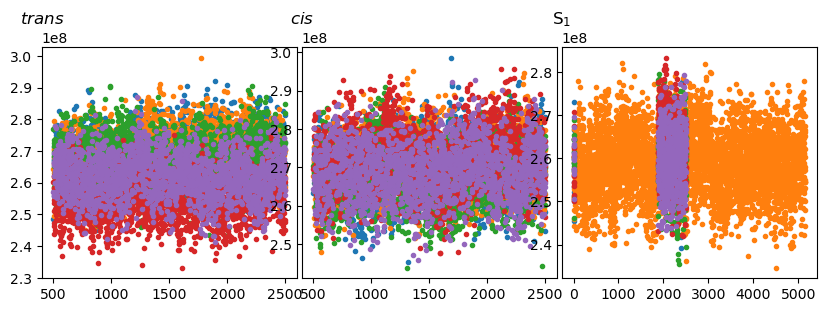

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
fig.subplots_adjust(wspace=0.02)

for i, iso in enumerate(["trans", "cis", "s1"]):
    ax[i].set_title(labels[iso], x=0.)
    for r in ["0", "1", "2", "3", "4"]:
        data = CED[iso][CED[iso]["replica"] == r].copy()
        ax[i].plot(data["time"], data["ced"], ".", label=f"{r}")
    #for N in CED[iso]:
    #    data = CED[iso][N].copy()
    #    ax[i].plot(data["time"] - 1000, data["ced"], "-", label=f"{N}")
"""        
    ax[i].legend()
    ax[i].set_ylabel(r"CED [$-E_{inter} \times Natomes / volume$] (J/m$^3$)")
    
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
    
    # ax[i].set_ylim(-3.15e8, -2.8e8)
    ax[i].set_ylim(2.70e8, 3.2e8)
    ax[i].set_xlim(0, 1700)
    ax[i].set_xlabel("time (ps)")
    
    ax[i].axvline(x=800, ls="--", lw=1., color="k")
    
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")

save_fig("ced_in_time.png", "../figures/")

plt.show()
"""

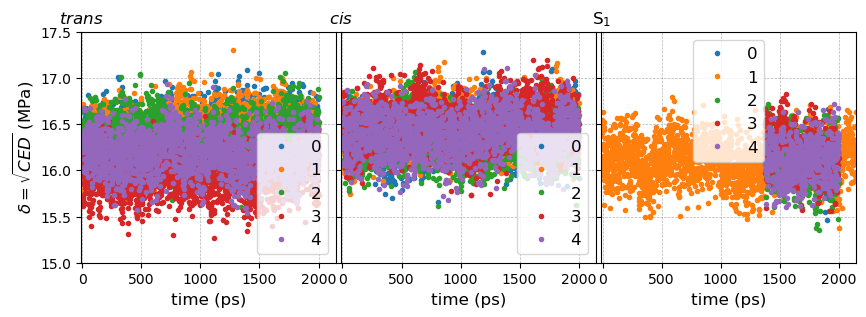

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
fig.subplots_adjust(wspace=0.02)

for i, iso in enumerate(["trans", "cis", "s1"]):
    ax[i].set_title(labels[iso], x=0.)
    for r in ["0", "1", "2", "3", "4"]:
        data = CED[iso][CED[iso]["replica"] == r].copy()
        ax[i].plot(data["time"]-500., data["delta"], ".", label=f"{r}")
        
    ax[i].legend()
    ax[i].set_ylabel(r"$\delta=\sqrt{CED}$ (MPa)")
    ax[i].grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
    ax[i].set_xlim(-10, 2150)
    ax[i].set_ylim(15, 17.5)
    ax[i].set_xlabel("time (ps)")
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_ylabel("")
    
save_fig("delta_in_time_pb.png", "../figures/")
plt.show()

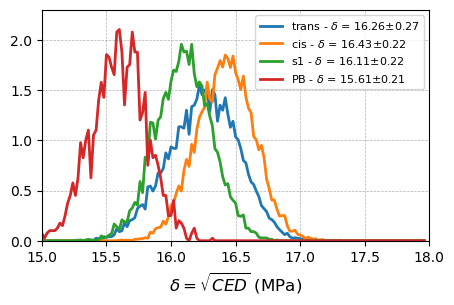

In [46]:
fig, ax = plt.subplots(ncols=1, figsize=(5, 3))
fig.subplots_adjust(wspace=0.05)

bins = np.arange(15, 18, 0.02)
# ax.set_title(labels[iso], x=0.)
for iso in CED:
    data = CED[iso].copy()
    hist, _ = np.histogram(data["delta"], bins=bins, density=True)
    mean = data["delta"].mean()
    std = data["delta"].std()
    ax.plot(
        bins[:-1],
        hist,
        "-",
        label=r"{} - $\delta$ = {:.2f}$\pm${:.2f}".format(iso, mean, std)
    )
    
    ax.legend(fontsize=8)
    ax.set_xlabel(r"$\delta=\sqrt{CED}$ (MPa)")
    
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.6)
    
    ax.set_xlim(15, 18)
    # ax[i].set_xlabel("time (ps)")
    
    ax.set_ylim(0, 2.3)

save_fig("delta_hist_pb.png", "../figures/")
plt.show()

In [ ]:
CED_mean["trans"]

## Impact of the Photochrome on the Polymeric Matrix

### RDF all-atoms

In [67]:
RDFS = {}

isomers = ["trans", "cis", "s1"]
solvents = ["THF", "PB"]
replicas = ["0", "1", "2", "3", "4"]

for iso in isomers:
    RDFS[iso] = {}
    for sol in solvents:
        RDFS[iso][sol] = {}
        for r in replicas: 
            if sol == "PB":
                path_file = "{}/{}/6_prod_{}/rdf_all_at_pc_env.csv".format(home_stamp, iso, r)
            elif sol == "THF":
                path_file = "{}/{}.thf/{}/md/rdf_all_at_pc_env.csv".format(home_gro, iso, r)
            try:
                RDFS[iso][sol][r] = pd.read_csv(path_file)
            except FileNotFoundError:
                print("ERROR: File not found")
                print(path_file)

                
                
RDFStot = {}
for iso in RDFS:
    RDFStot[iso] = {}
    for sol in RDFS[iso]:
        RDFStot[iso][sol] = []
        for r in RDFS[iso][sol]:
            RDFStot[iso][sol].append(RDFS[iso][sol][r])
        RDFStot[iso][sol] = pd.DataFrame(np.mean(RDFStot[iso][sol], axis=0), columns=["r", "g_r"])

Image 9 saved!
/home/ovillegas/figures/figPapers/img_0009_RDFs_allatoms.png


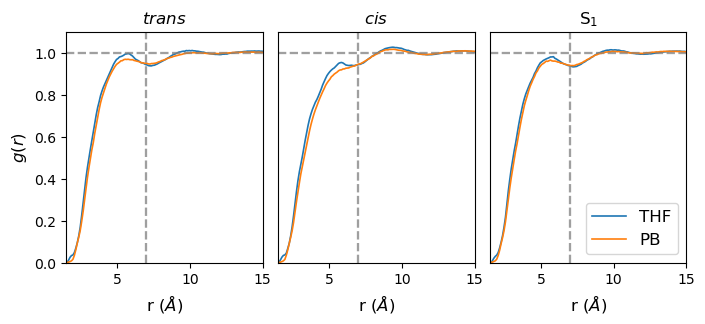

In [291]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(8,3))
fig.subplots_adjust(wspace=0.08)

for i, iso in enumerate(RDFStot):
    for sol in RDFStot[iso]:
        ax[i].set_title(labels[iso])
        
        data = RDFStot[iso][sol].copy()
        
        ax[i].plot(data["r"], data["g_r"], label=f"{sol}", ls="-", lw=1.2)
        
        ax[i].set_xlim(1.5, 15.)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xlabel(r"r ($\AA$)")
        ax[i].set_ylabel(r"$g(r)$")
        ax[i].axvline(x=7., ls="--", color="gray", lw=1.6, alpha=0.5)
        ax[i].axhline(y=1., ls="--", color="gray", lw=1.6, alpha=0.5)
        
        if i != 0:
            ax[i].get_yaxis().set_visible(False)
        
ax[2].legend()

SAVEFig.saveFig("RDFs_allatoms.png")
plt.show()

#### PBOH

In [68]:
RDFSoh = {
    "PB": {"trans": {}, "cis": {}},
    "PB-OH": {"trans": {}, "cis": {}}
}

replicas = ["0", "1", "2", "3", "4"]

for system in RDFSoh:
    for iso in RDFSoh[system]:
        for r in replicas: 
            if system == "PB":
                path_file = "{}/{}/6_prod_{}/rdf_all_at_pc_env.csv".format(home_stamp, iso, r)
            elif system == "PB-OH":
                path_file = "{}/{}/9_prod_OH_{}/rdf_all_at_pc_env.csv".format(home_stamp, iso, r)
            
            try:
                RDFSoh[system][iso][r] = pd.read_csv(path_file)
            except FileNotFoundError:
                print("ERROR: File not found")
                print(path_file)


RDFStot_oh = {}

for sol in RDFSoh:
    RDFStot_oh[sol] = {}
    for iso in RDFSoh[sol]:
        RDFStot_oh[sol][iso] = []
        for r in RDFSoh[sol][iso]:
            RDFStot_oh[sol][iso].append(RDFSoh[sol][iso][r])
        RDFStot_oh[sol][iso] = pd.DataFrame(np.mean(RDFStot_oh[sol][iso], axis=0), columns=["r", "g_r"])

In [69]:
RDFStot_oh["THF"] = {}
RDFStot_oh["THF"]["trans"] = RDFStot["trans"]["THF"]
RDFStot_oh["THF"]["cis"] = RDFStot["cis"]["THF"]

Image 11 saved!
/home/ovillegas/figures/figPapers/img_0011_RDFS_all_with_OH.png


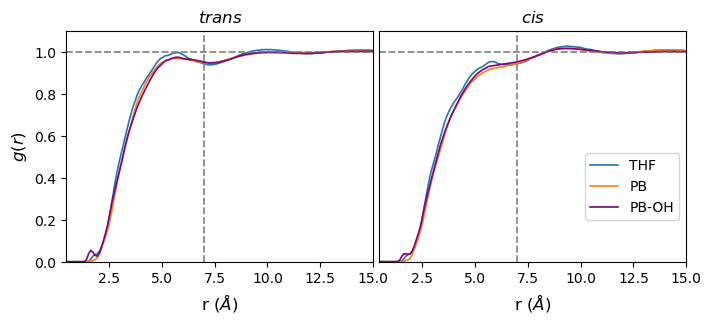

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))
fig.subplots_adjust(hspace=0.05, wspace=0.02)

# fig.suptitle(
#     f"RDFs all atoms",
#     fontweight="bold",
#     fontsize=12,
#     y=1.05,
#     x=0.5,
#     ha = "center"
# )

for i, iso in enumerate(["trans", "cis"]):
    for sol in ["THF", "PB", "PB-OH"]:
        dataM = RDFStot_oh[sol][iso].copy()
        ax[i].set_title(r"$%s$" % iso)
        
        ax[i].plot(
            dataM["r"], dataM["g_r"],
            label=f"{sol}",
            ls="-",
            lw=1.2,
            color=colors[sol],
            alpha=1.
        )
        
        ax[i].set_xlim(.5, 15.)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xlabel(r"r ($\AA$)")
        ax[i].set_ylabel(r"$g(r)$")
        ax[i].axvline(x=7., ls="--", color="gray", lw=1.3, alpha=0.5)
        ax[i].axhline(y=1., ls="--", color="gray", lw=1.3, alpha=0.5)
        
        if i > 0:
            # ax[i].set_yticks([])
            ax[i].get_yaxis().set_visible(False)
            
ax[1].legend(fontsize=10, bbox_to_anchor=(1., 0.5))
        
# saveFig("RDFS_all_means_OH.png")
SAVEFig.saveFig("RDFS_all_with_OH.png")
plt.show()

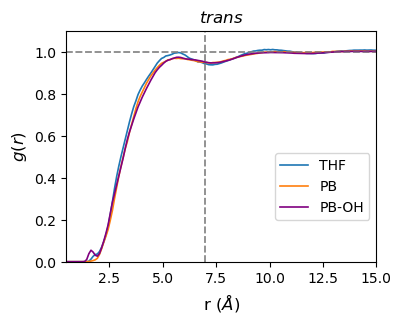

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3))
fig.subplots_adjust(hspace=0.05, wspace=0.02)

table = {}

iso = "trans"
for sol in ["THF", "PB", "PB-OH"]:
    dataM = RDFStot_oh[sol][iso].copy()
    ax.set_title(r"$%s$" % iso)
    if sol == "THF":
        table["r"] = dataM["r"].values
    
    ax.plot(
        dataM["r"], dataM["g_r"],
        label=f"{sol}",
        ls="-",
        lw=1.2,
        color=colors[sol],
        alpha=1.
    )
    table[f"g_r_{sol}"] = dataM["g_r"].values
    
    ax.set_xlim(.5, 15.)
    ax.set_ylim(0.0, 1.1)
    ax.set_xlabel(r"r ($\AA$)")
    ax.set_ylabel(r"$g(r)$")
    ax.axvline(x=7., ls="--", color="gray", lw=1.3, alpha=0.5)
    ax.axhline(y=1., ls="--", color="gray", lw=1.3, alpha=0.5)

            
ax.legend(fontsize=10, bbox_to_anchor=(1., 0.5))
        
saveFig("RDFS_trans_means.png")
# SAVEFig.saveFig("RDFS_all_with_OH.png")
plt.show()

In [75]:
pd.DataFrame(table).to_csv(f"{send_to_aurelie}/data_rdf_trans_PB_THF.csv", float_format="%.6f", index=False)

### Size and shape analysis

In [133]:
POLPROP = {
    "Rg": {
        "color": "#2a90a6",
        "binwidth": .1,
        "xlim": [0.8, 2.5],  # size 0.5  size vs distance 0.8
        "label": "Radius of gyration (nm)",
        "units": "nm",
        "bins": (0.5, 3.08, 0.08)  # 0.5
    },
    "dmax": {
        "color": "#5b557b",
        "binwidth": .3,
        "xlim": [1.2, 8.0],
        "label": "Max. distance (nm)",
        "units": "nm",
        "bins": (1.0, 9.1, 0.1)
    },
    "k2": {
        "color": "#fea6ad",
        "binwidth": .05,
        "xlim": [0, 1],
        "label": "Shape anisotropy",
        "units": "",
        "bins": (0., 1.02, 0.02)
    },
    "rdf": {
        "color": "#3293f0",
        "xlim": [0.25, 2.5],
        "label": "g(r) PC - POL",
        "ylim": [0, 300],
        "units": ""
        
    },
    "rdf_CM": {
        "color": "#00cc99",
        "xlim": [0.25, 2.5],
        "label": r"g(r) PC$_{CM}$ - PB$_{CM}$",
        "units": "",
        "ylim": [0, 10]
        
    },
    "distance": {
        "color": "#66c0c0",
        "binwidth": 0.01,
        "xlim": [0, 4.0],
        "label": "distance",
        "units": "nm"
    }
}

In [77]:
replicas = ["0", "1", "2", "3", "4"]
systems = ["trans", "cis", "s1", "pb"]
SIZES = {}

for system in systems:
    SIZES[system] = {}
    for r in replicas:
        path_mol = ""
        if system == "pb":
            path_mol += "{}/{}/6_prod/molprop.csv".format(home_stamp, "polymer")
        else:
            path_mol += "{}/{}/6_prod_{}/molprop.csv".format(home_stamp, system, r)

        data = pd.read_csv(f"{path_mol}")
        data["time"] = data["frame"].apply(nbconfig.toTime, freq=1.0, t0=1.0)
        data["Rg"] *= 0.1
        data["dmax"] *= 0.1
        
        if system == "pb":
            data["idx"] += 1
            SIZES[system][0] = data
            continue
        else:
            SIZES[system][r] = data[data["idx"] != 0]

        
SIZESM = {}
for system in SIZES:
    SIZESM[system] = {}
    SIZESM[system] = pd.concat(
        [SIZES[system][d] for d in SIZES[system]],
        ignore_index=True
    )


In [356]:
colorsIsomer = {
    "trans": "#41c325",
    "cis": "#f4c90f",
    "s1": "#e584ac",
    "pb" : "#90634a"
}

Image 10 saved!
/home/ovillegas/figures/figPapers/img_0010_Sizes_shapes_systems.png


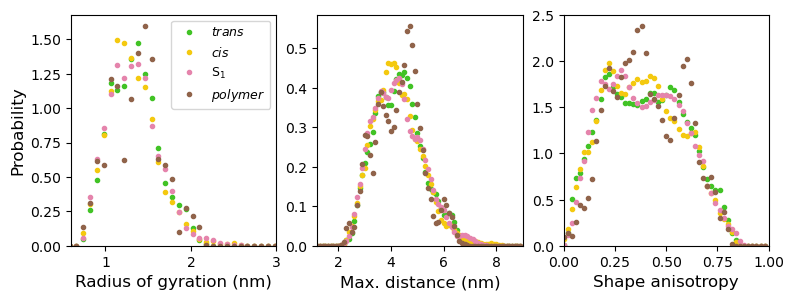

In [361]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(9,3))
fig.subplots_adjust(wspace=0.2)

for i, prop in enumerate(["Rg", "dmax", "k2"]):
    # ax[i].set_title(prop)
    formatProp = POLPROP[prop]

    for iso in SIZESM:
        data = SIZESM[iso].copy()
        
        values = data[prop].values
        bins = np.arange(*formatProp["bins"])
        hist, _ = np.histogram(values, bins=bins, density=True)
        ax[i].plot(
            bins[:-1],
            hist, ".", ms = 6,
            label = labels[iso],
            color = colorsIsomer[iso]
        )# label = "{} - {:.3f} $\pm$ {:.3f}".format(iso, values.mean(), values.std()))
            # print(bins)
            
    ax[i].set_xlabel(formatProp["label"])
    ax[i].set_xlim(formatProp["xlim"])
    ax[i].set_ylim(ymin=0.0)
    
ax[0].legend(fontsize=9)
ax[0].set_ylabel("Probability")

SAVEFig.saveFig("Sizes_shapes_systems.png")
plt.show()        

In [78]:
PROPvals = {
    "index": [],
    "columns": [],
    "data": [],
    "index_names": ["system"],
    "column_names": ["property", ""]
}

for iso in SIZESM:
    PROPvals["index"].append(iso)
    
    
line_trans = []
line_cis = []
line_s1 = []
line_pb = []

for prop in ["Rg", "dmax", "k2"]:
    formatProp = POLPROP[prop]
    PROPvals["columns"].append((prop, "mean"))
    PROPvals["columns"].append((prop, "std"))
    for iso in SIZESM:
        data = SIZESM[iso].copy()
        values = data[prop]
        
        # print(iso, prop, values.mean(), values.std())
        if iso == "trans":
            line_trans.append(values.mean())
            line_trans.append(values.std())
        elif iso == "cis":
            line_cis.append(values.mean())
            line_cis.append(values.std())
        elif iso == "s1":
            line_s1.append(values.mean())
            line_s1.append(values.std())
        elif iso == "pb":
            line_pb.append(values.mean())
            line_pb.append(values.std())
            
        

In [387]:
PROPvals["data"] = np.array([
    line_trans,
    line_cis,
    line_s1,
    line_pb
])

In [390]:
PROPtab = pd.DataFrame.from_dict(PROPvals, orient='tight')
PROPtab.

property        Rg                dmax                  k2          
              mean       std      mean       std      mean       std
system                                                              
trans     1.377254  0.276626  4.344316  0.902090  0.405434  0.192234
cis       1.353180  0.284053  4.290865  0.919552  0.394578  0.186163
s1        1.362170  0.290349  4.305773  0.942881  0.399656  0.187795
pb        1.393991  0.293549  4.342179  0.885639  0.418146  0.174793

In [391]:
PROPtab.style.format(precision=3).to_latex(
    "propSizeTab.tex",
    label="tab:propSize",
    caption="Average values of the system's polymer chains."
)

#### PBOH

In [80]:
isomers = ["trans", "cis"]
replicas = ["0", "1", "2", "3", "4"]
SIZES = {}

for iso in isomers:
    SIZES[iso] = {}
    for r in replicas:
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        try:
            data = pd.read_csv(f"{path_mol}/molprop.csv")
        except FileNotFoundError:
            print("path:", path_mol, "NOT FOUNDED")
            continue
        if len(data) == 0:
            print("path:", path_mol, "NOT FOUNDED")
            continue

        data["time"] = data["frame"].apply(nbconfig.toTime, freq=.1, t0=1.0)
        data["Rg"] *= 0.1
        data["dmax"] *= 0.1
        
        SIZES[iso][r] = data[data["idx"] != 0]
        
SIZESMoh = {"cis": None, "trans": None}

for iso in SIZESMoh:
    SIZESMoh[iso] = pd.concat([SIZES[iso][d] for d in SIZES[iso]], ignore_index=True)

In [244]:
SIZESMoh["trans"]

,frame,idx,Natoms,Rg,k2,dmax,x,y,z,time
0,0,1,304,1.377,0.337,4.188,25.481,37.746,2.263,1.0
1,0,2,314,1.682,0.711,5.604,27.993,53.834,39.975,1.0
2,0,3,284,0.981,0.233,2.976,16.440,14.757,12.196,1.0
3,0,4,284,1.961,0.814,6.342,21.383,41.427,26.963,1.0
4,0,5,304,1.933,0.687,5.881,39.150,58.758,2.343,1.0
...,...,...,...,...,...,...,...,...,...,...
6920923,19999,68,304,0.862,0.142,2.677,20.055,48.866,41.081,2000.9
6920924,19999,69,274,1.397,0.430,4.247,21.497,41.690,57.061,2000.9
6920925,19999,70,294,1.183,0.477,3.705,18.892,36.914,47.776,2000.9
6920926,19999,71,294,1.408,0.241,3.769,26.256,18.732,55.907,2000.9


Image 12 saved!
/home/ovillegas/figures/figPapers/img_0012_Sizes_PBOH_vs_PB_prop.png


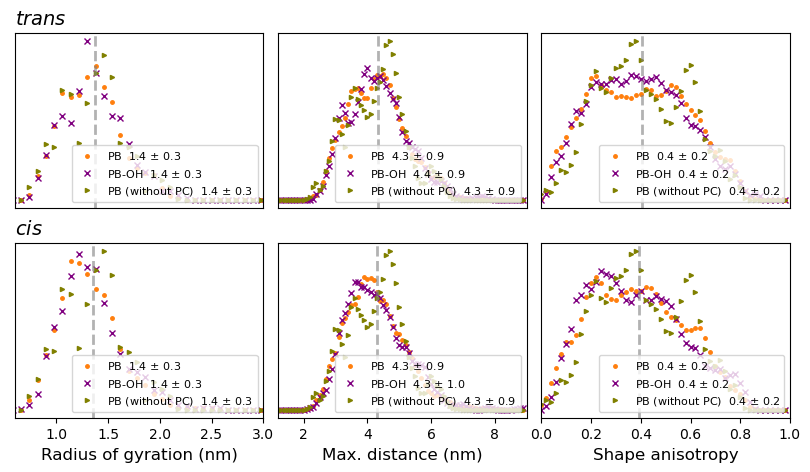

In [56]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

fig.subplots_adjust(hspace=0.2, wspace=0.06)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

for i, iso in enumerate(["trans", "cis"]):
    ax[i, 0].set_title(labels[iso], horizontalalignment="left", loc="left", fontsize=14)
    for j, prop in enumerate(["Rg", "dmax", "k2"]):
        data = SIZESM[iso]
        formProp = POLPROP[prop]
        
        bins = np.arange(*formProp["bins"])
        hist, _ = np.histogram(data[prop], bins=bins, density=True)
        
        ax[i,j].plot(
                bins[:-1],
                hist, ".", ms = 5,
                color=colors["PB"],
                label = r"PB  %.1f $\pm$ %.1f" % (data[prop].mean(), data[prop].std())
            )
        
        data_oh = SIZESMoh[iso]
        hist, _ = np.histogram(data_oh[prop], bins=bins, density=True)
        ax[i,j].plot(
                bins[:-1],
                hist, "x", ms = 5,
                color=colors["PB-OH"],
                label = r"PB-OH  %.1f $\pm$ %.1f" % (data_oh[prop].mean(), data_oh[prop].std())
            )
        
        
        ax[i, j].set_xlabel(formProp["label"])
        ax[i, j].set_xlim(formProp["xlim"])
        
        pol = SIZESM["pb"]
        hist, _ = np.histogram(pol[prop], bins=bins, density=True)
        ax[i,j].plot(
                bins[:-1],
                hist, ">", ms = 3, #label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
                color="olive",
                label = r"PB (without PC)  %.1f $\pm$ %.1f" % (pol[prop].mean(), pol[prop].std())
            )
        
        ax[i, j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)
        
        if i != 1:
            ax[i, j].get_xaxis().set_visible(False)
            
        if j == 0:
            ax[i, j].get_yaxis().set_ticks([])
        else:
            ax[i, j].get_yaxis().set_visible(False)
            
        ax[i, j].legend(fontsize=8, loc="lower right")

            
# saveFig("sizes_shapes_systems.png")
## saveFig("sizes_PBOH_vs_PB_prop.png")
SAVEFig.saveFig("Sizes_PBOH_vs_PB_prop.png")
plt.show()

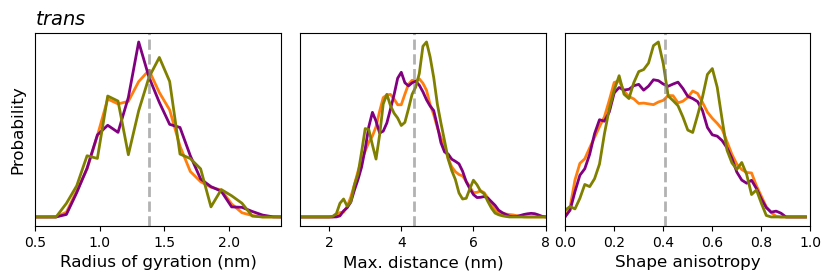

In [128]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2.5))

fig.subplots_adjust(hspace=0.2, wspace=0.08)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

iso = "trans"

table = {}

ax[0].set_title(labels[iso], horizontalalignment="left", loc="left", fontsize=14)
for j, prop in enumerate(["Rg", "dmax", "k2"]):
    data = SIZESM[iso]
    formProp = POLPROP[prop]
    table[prop] = {}
    
    bins = np.arange(*formProp["bins"])
    hist, _ = np.histogram(data[prop], bins=bins, density=True)
    
    table[prop][f"{prop}_bins"]  = bins[:-1]
    
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 5,
            color=colors["PB"],
            label = r"PB  %.1f $\pm$ %.1f" % (data[prop].mean(), data[prop].std())
        )

    table[prop]["hist_PB"]  = hist
    
    data_oh = SIZESMoh[iso]
    hist, _ = np.histogram(data_oh[prop], bins=bins, density=True)
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 5,
            color=colors["PB-OH"],
            label = r"PB-OH  %.1f $\pm$ %.1f" % (data_oh[prop].mean(), data_oh[prop].std())
        )
    
    table[prop]["hist_PBOH"]  = hist
    
    
    ax[j].set_xlabel(formProp["label"])
    ax[j].set_xlim(formProp["xlim"])
    
    pol = SIZESM["pb"]
    hist, _ = np.histogram(pol[prop], bins=bins, density=True)
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 3, #label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color="olive",
            label = r"PB (without PC)  %.1f $\pm$ %.1f" % (pol[prop].mean(), pol[prop].std())
        )
    
    table[prop][f"hist_PBonly"]  = hist
    
    ax[j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)

        
    if j == 0:
        ax[j].get_yaxis().set_ticks([])
    else:
        ax[j].get_yaxis().set_visible(False)
        
    #ax[j].legend(fontsize=8, loc="lower right")

ax[0].set_ylabel("Probability")
saveFig("sizes_shapes_trans.png")
## saveFig("sizes_PBOH_vs_PB_prop.png")
# SAVEFig.saveFig("Sizes_PBOH_vs_PB_prop.png")
plt.show()

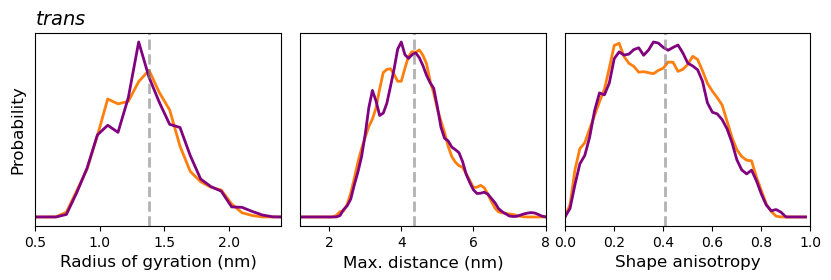

In [127]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2.5))

fig.subplots_adjust(hspace=0.2, wspace=0.08)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

iso = "trans"

table = {}

ax[0].set_title(labels[iso], horizontalalignment="left", loc="left", fontsize=14)
for j, prop in enumerate(["Rg", "dmax", "k2"]):
    data = SIZESM[iso]
    formProp = POLPROP[prop]
    table[prop] = {}
    
    bins = np.arange(*formProp["bins"])
    hist, _ = np.histogram(data[prop], bins=bins, density=True)
    
    table[prop][f"{prop}_bins"]  = bins[:-1]
    
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 5,
            color=colors["PB"],
            label = r"PB  %.1f $\pm$ %.1f" % (data[prop].mean(), data[prop].std())
        )

    table[prop]["hist_PB"]  = hist
    
    data_oh = SIZESMoh[iso]
    hist, _ = np.histogram(data_oh[prop], bins=bins, density=True)
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 5,
            color=colors["PB-OH"],
            label = r"PB-OH  %.1f $\pm$ %.1f" % (data_oh[prop].mean(), data_oh[prop].std())
        )
    
    table[prop]["hist_PBOH"]  = hist
    
    
    ax[j].set_xlabel(formProp["label"])
    ax[j].set_xlim(formProp["xlim"])
    
    ax[j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)

        
    if j == 0:
        ax[j].get_yaxis().set_ticks([])
    else:
        ax[j].get_yaxis().set_visible(False)
        
    #ax[j].legend(fontsize=8, loc="lower right")

ax[0].set_ylabel("Probability")
saveFig("sizes_shapes_trans_PB_PBOH.png")
## saveFig("sizes_PBOH_vs_PB_prop.png")
# SAVEFig.saveFig("Sizes_PBOH_vs_PB_prop.png")
plt.show()

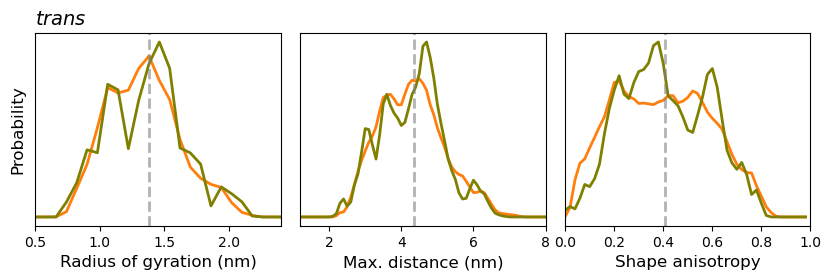

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,2.5))

fig.subplots_adjust(hspace=0.2, wspace=0.08)

# fig.suptitle(
#     "Sizes and shape analysis of the polymeric matrix",
#     fontweight="bold",
#     fontsize=15,
#     y=0.95
# )

iso = "trans"

table = {}

ax[0].set_title(labels[iso], horizontalalignment="left", loc="left", fontsize=14)
for j, prop in enumerate(["Rg", "dmax", "k2"]):
    data = SIZESM[iso]
    formProp = POLPROP[prop]
    table[prop] = {}
    
    bins = np.arange(*formProp["bins"])
    hist, _ = np.histogram(data[prop], bins=bins, density=True)
    
    table[prop][f"{prop}_bins"]  = bins[:-1]
    
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 5,
            color=colors["PB"],
            label = r"PB  %.1f $\pm$ %.1f" % (data[prop].mean(), data[prop].std())
        )

    table[prop]["hist_PB"]  = hist
    
    
    ax[j].set_xlabel(formProp["label"])
    ax[j].set_xlim(formProp["xlim"])
    
    pol = SIZESM["pb"]
    hist, _ = np.histogram(pol[prop], bins=bins, density=True)
    ax[j].plot(
            bins[:-1],
            hist, "-", ms = 3, #label = sol.replace("POL", "PB") + r"  %.1f $\pm$ %.1f$^{\circ}$" % (ndata[torsion].mean(), ndata[torsion].std()),
            color="olive",
            label = r"PB (without PC)  %.1f $\pm$ %.1f" % (pol[prop].mean(), pol[prop].std())
        )
    
    table[prop][f"hist_PBonly"]  = hist
    
    ax[j].axvline(x=data[prop].mean(), ls="--", color="gray", lw=2.0, alpha=0.6)

        
    if j == 0:
        ax[j].get_yaxis().set_ticks([])
    else:
        ax[j].get_yaxis().set_visible(False)
        
    #ax[j].legend(fontsize=8, loc="lower right")

ax[0].set_ylabel("Probability")
saveFig("sizes_shapes_trans_PB_PBonly.png")
## saveFig("sizes_PBOH_vs_PB_prop.png")
# SAVEFig.saveFig("Sizes_PBOH_vs_PB_prop.png")
plt.show()

In [102]:
pd.DataFrame(table["Rg"]).to_csv(f"{send_to_aurelie}/data_Rg_trans.csv", float_format="%.6f", index=False)
pd.DataFrame(table["dmax"]).to_csv(f"{send_to_aurelie}/data_dmax_trans.csv", float_format="%.6f", index=False)
pd.DataFrame(table["k2"]).to_csv(f"{send_to_aurelie}/data_k2_trans.csv", float_format="%.6f", index=False)

### Size en function of distance from PC

#### Closest distance from photochrome

In [103]:
%%time

replicas = ["0", "1", "2", "3", "4"]
isomers = ["trans", "cis", "s1"]
DISTCLOSE = {}
kwargs_bin_CD = {"rmin": 0.0, "rmax": 2.05, "binwidth": 0.05}

for iso in isomers:
    DISTCLOSE[iso] = {}
    for r in replicas:
        print(f"Isomer {iso} - Replica {r}")
        DISTCLOSE[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        
        # load distances
        dist = pd.read_csv(f"{path_mol}/closest_d_To_0.csv")
        dist["distance"] *= 0.1
        
        # load sizes
        data = pd.read_csv(f"{path_mol}/molprop.csv")
        data["time"] = data["frame"].apply(nbconfig.toTime, freq=1.0, t0=1.0)
        data["Rg"] *= 0.1
        data["dmax"] *= 0.1
        
        # polymer data
        pol = data[data["idx"] != 0].copy()
        
        try:
            # join distances and sizes
            dprop = pd.DataFrame({
            "distance": dist["distance"].values,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values
            })
        except ValueError:
            print("distance shape:", dist.shape, len(dist))
            print("size shape", pol.shape, len(pol))
            print("WARNING: they do not have the same size.")
            
            if len(pol) < len(dist):
                dprop = pd.DataFrame({
                    "distance": dist["distance"].values[:len(pol)],
                    "Rg": pol["Rg"].values,
                    "k2": pol["k2"].values,
                    "dmax": pol["dmax"].values,
                    "time": pol["time"].values,
                    "frame": pol["frame"].values
                })
            elif len(dist) < len(pol):
                dprop = pd.DataFrame({
                    "distance": dist["distance"].values,
                    "Rg": pol["Rg"].values[:len(dist)],
                    "k2": pol["k2"].values[:len(dist)],
                    "dmax": pol["dmax"].values[:len(dist)],
                    "time": pol["time"].values[:len(dist)],
                    "frame": pol["frame"].values[:len(dist)]
                })
                
        # save dprop
        DISTCLOSE[iso][r]["dprop"] = dprop
        
        # Load system and search box dimensions
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        box_in_frame[:, 0:3] *= 0.1
        
        # Compute RDF
        rdf = rdf_from_dist(dprop, box_in_frame, **kwargs_bin_CD)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        dprop_binned["count"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "frame"])
        
        DISTCLOSE[iso][r]["rdf"] = rdf
        DISTCLOSE[iso][r]["dbind"] = dprop_binned
        print(80 * "=")

print("Finish!")

Isomer trans - Replica 0
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.89 s
Number of frames 2000
Isomer trans - Replica 1
Reading log file - done in 0.18 s
Reading fatomes file - done in 0.45 s
Searching connectivity - done in 1.91 s
Number of frames 2000
Isomer trans - Replica 2
Reading log file - done in 0.20 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.90 s
Number of frames 2000
Isomer trans - Replica 3
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.89 s
Number of frames 2000
Isomer trans - Replica 4
Reading log file - done in 0.65 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.91 s
Number of frames 2000
Isomer cis - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.89 s
Number of frames 2000
Isomer cis - Replica 1
Reading log file - done i

In [104]:
%%time

replicas = ["0", "1", "2", "3", "4"]
isomers = ["trans", "cis", "s1"]
RDFGLOB = {}
kwargs_bin_CD = {"rmin": 0.0, "rmax": 2.05, "binwidth": 0.05}

for iso in isomers:
    RDFGLOB[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in replicas:
        isoms += " " + r
        print(f"Isomer {iso} - Replicas {isoms}")
        RDFGLOB[iso][isoms] = {}

        data = DISTCLOSE[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
 
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), "-->", count_frames + len(frames))
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)
        
        # Load system and search box dimensions
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        # compute RDF
        rdf = rdf_from_dist(newData, newBoxs, **kwargs_bin_CD)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bin_CD)
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        newData["count"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "frame"])
        
        RDFGLOB[iso][isoms]["dprop"] = newData
        RDFGLOB[iso][isoms]["rdf"] = rdf
        RDFGLOB[iso][isoms]["dbinned"] = dprop_binned

        count_frames += len(frames)
        print(80 * "=")
        
print("Finish!")

Isomer trans - Replicas  0
Numbers of frames: 2000 --> 2000
1
Data size: (101595, 7)
Reading log file - Reading fatomes file - done in 0.13 s
Searching connectivity - done in 2.33 s
Number of frames 2501
(2501, 6)
Isomer trans - Replicas  0 1
Numbers of frames: 2000 --> 4000
2
Data size: (218072, 7)
Reading log file - Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.89 s
Number of frames 2501
(5002, 6)
Isomer trans - Replicas  0 1 2
Numbers of frames: 2000 --> 6000
3
Data size: (331756, 7)
Reading log file - Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.89 s
Number of frames 2501
(7503, 6)
Isomer trans - Replicas  0 1 2 3
Numbers of frames: 2000 --> 8000
4
Data size: (442880, 7)
Reading log file - Reading fatomes file - done in 0.13 s
Searching connectivity - done in 1.88 s
Number of frames 2501
(10004, 6)
Isomer trans - Replicas  0 1 2 3 4
Numbers of frames: 2000 --> 10000
5
Data size: (556742, 7)
Reading log file - Reading fatomes fi

Image 13 saved!
/home/ovillegas/figures/figPapers/img_0013_Sizes_vs_distance_PB_PC.png


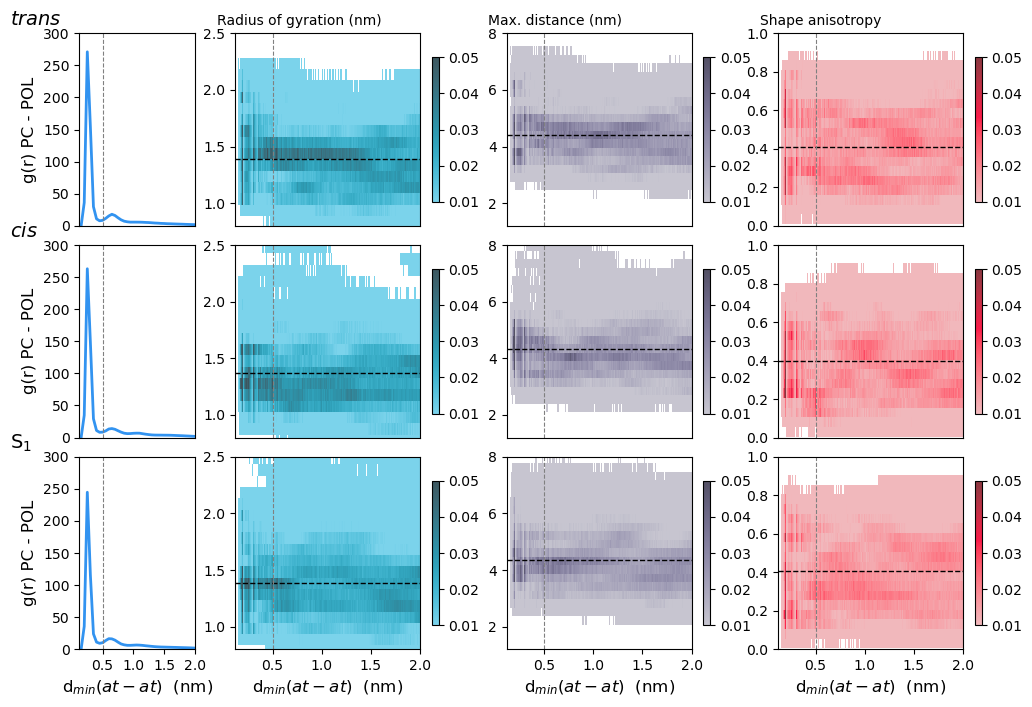

In [184]:
properties = {
    "rdf": [0, 300],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

isomers = ["trans", "cis", "s1"]

nrows = len(isomers)
ncols = len(properties)


fig = plt.figure(figsize=(12,8))
gs = GridSpec(nrows, ncols, width_ratios=[0.5, 1, 1, 1], hspace=0.1, wspace=0.2)

for i, iso in enumerate(isomers):
    for j, prop in enumerate(properties):
        formProp = POLPROP[prop]

        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ax.set_title(labels[iso], fontsize=14, horizontalalignment="left", loc="left", x=-0.6)  # - Replicas 0 1 2 3 4
        elif i == 0:
            ax.set_title(formProp["label"], fontsize=10, horizontalalignment="left", loc="left", x=-0.1)
        
        data = RDFGLOB[iso][" 0 1 2 3 4"]["dprop"].copy()
        data = data[data["bin"] > data["bin"].min() + 0.02]
        data = data[data["distance"] <= 2.0]
        
        rdf = RDFGLOB[iso][" 0 1 2 3 4"]["rdf"].copy()        
        if prop == "rdf":
            ax.plot(rdf["bin"], rdf["gr"], label=r, color=formProp["color"])
            ax.set_ylim(formProp["ylim"])
            ax.set_ylabel(formProp["label"])
        else:
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["count"],
                    stat="count",
                    ax=ax,
                    binwidth=[POLPROP["distance"]["binwidth"], formProp["binwidth"]],
                    color=formProp["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            plot.collections[0].set_clim(0.01, 0.05)
            ax.axhline(y=data[prop].mean(), ls="--", color="black", lw=1.0)
            ax.set_ylim(formProp["xlim"])
            ax.set_ylabel("")
            
        ax.axvline(x=0.5, ls="--", color="gray", lw=.8)
            
            
        ax.set_xlabel(r"d$_{min}({at - at})$  (nm)")
        ax.set_xticks(np.arange(0, 2.5, 0.5))
        ax.set_xlim(0.12, 2.)
        
        
        if i != 2:
            ax.get_xaxis().set_visible(False)
        
        
        
    
SAVEFig.saveFig("Sizes_vs_distance_PB_PC.png")
plt.show()

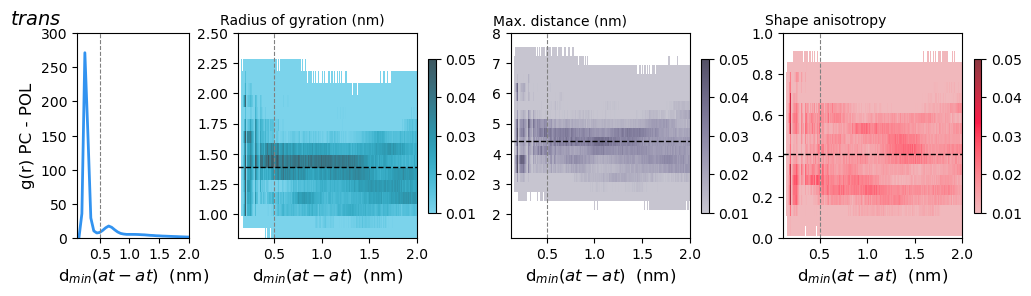

In [134]:
properties = {
    "rdf": [0, 300],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

isomers = ["trans"]

nrows = len(isomers)
ncols = len(properties)


fig = plt.figure(figsize=(12,8/3))
gs = GridSpec(nrows, ncols, width_ratios=[0.5, 1, 1, 1], hspace=0.1, wspace=0.25)

for i, iso in enumerate(isomers):
    for j, prop in enumerate(properties):
        formProp = POLPROP[prop]

        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ax.set_title(labels[iso], fontsize=14, horizontalalignment="left", loc="left", x=-0.6)  # - Replicas 0 1 2 3 4
        elif i == 0:
            ax.set_title(formProp["label"], fontsize=10, horizontalalignment="left", loc="left", x=-0.1)
        
        data = RDFGLOB[iso][" 0 1 2 3 4"]["dprop"].copy()
        data = data[data["bin"] > data["bin"].min() + 0.02]
        data = data[data["distance"] <= 2.0]
        
        rdf = RDFGLOB[iso][" 0 1 2 3 4"]["rdf"].copy()        
        if prop == "rdf":
            ax.plot(rdf["bin"], rdf["gr"], label=r, color=formProp["color"])
            ax.set_ylim(formProp["ylim"])
            ax.set_ylabel(formProp["label"])
        else:
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["count"],
                    stat="count",
                    ax=ax,
                    binwidth=[POLPROP["distance"]["binwidth"], formProp["binwidth"]],
                    color=formProp["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            plot.collections[0].set_clim(0.01, 0.05)
            ax.axhline(y=data[prop].mean(), ls="--", color="black", lw=1.0)
            ax.set_ylim(formProp["xlim"])
            ax.set_ylabel("")
            
        ax.axvline(x=0.5, ls="--", color="gray", lw=.8)
            
            
        ax.set_xlabel(r"d$_{min}({at - at})$  (nm)")
        ax.set_xticks(np.arange(0, 2.5, 0.5))
        ax.set_xlim(0.12, 2.)
        
        
    
# SAVEFig.saveFig("Sizes_vs_distance_PB_PC.png")
saveFig("Sizes_vs_distance_PB_PC_trans.png")
plt.show()

##### PBOH

In [108]:
%%time

replicas = ["1", "2", "3", "4"]
isomers = ["trans", "cis"]
DISTCLOSE_oh = {}
kwargs = {
    "rmin": 0.00,
    "rmax": 3.01,
    "binwidth": 0.01
}

for iso in isomers:
    DISTCLOSE_oh[iso] = {}
    for r in replicas:
        print(f"Isomer {iso} - Replica {r}")
        DISTCLOSE_oh[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        
        dist = pd.read_csv(f"{path_mol}/closest_d_To_0.csv")
        dist["distance"] *= 0.1
        
        dat = pd.read_csv(f"{path_mol}/molprop.csv")
        dat["time"] = dat["frame"].apply(nbconfig.toTime, freq=1.0, t0=1.0)
        dat["Rg"] *= 0.1
        dat["dmax"] *= 0.1
        
        pol = dat[dat["idx"] != 0].copy()
        dprop = pd.DataFrame({
            "distance": dist["distance"].values,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values
        })
        
        # print(dprop)
        DISTCLOSE_oh[iso][r]["dprop"] = dprop
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, **kwargs)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        
        
        DISTCLOSE_oh[iso][r]["rdf"] = rdf
        DISTCLOSE_oh[iso][r]["dbind"] = dprop_binned
        print(80 * "=")

print("Finish!")

Isomer trans - Replica 1
Reading log file - done in 0.26 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.91 s
Number of frames 20000
Isomer trans - Replica 2
Reading log file - done in 0.25 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.92 s
Number of frames 20000
Isomer trans - Replica 3
Reading log file - done in 0.24 s
Reading fatomes file - done in 0.59 s
Searching connectivity - done in 1.90 s
Number of frames 20000
Isomer trans - Replica 4
Reading log file - done in 0.25 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.90 s
Number of frames 20000
Isomer cis - Replica 1
Reading log file - done in 0.25 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 2.36 s
Number of frames 20000
Isomer cis - Replica 2
Reading log file - done in 0.26 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.90 s
Number of frames 20000
Isomer cis - Replica 3
Reading log file - do

In [109]:
%%time

RDFGLOB_oh = {}
kwargs = {
    "rmin": 0.00,
    "rmax": 3.01,
    "binwidth": 0.01
}

for iso in DISTCLOSE_oh:
    RDFGLOB_oh[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in DISTCLOSE_oh[iso]:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")
        RDFGLOB_oh[iso][isoms] = {}
        data = DISTCLOSE_oh[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)
                
        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        # STDCUM3[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        # print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, **kwargs)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        newData["count"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "frame"])
        
        RDFGLOB_oh[iso][isoms]["dprop"] = newData
        RDFGLOB_oh[iso][isoms]["rdf"] = rdf
        RDFGLOB_oh[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: trans - Replicas:  1
Numbers of frames: 20000 20000
1
Data size: (1439849, 7)
Reading log file - done in 0.25 s
Number of frames 20000
(20000, 3)
Isomer: trans - Replicas:  1 2
Numbers of frames: 20000 40000
2
Data size: (2843951, 7)
Reading log file - done in 0.26 s
Number of frames 20000
(40000, 3)
Isomer: trans - Replicas:  1 2 3
Numbers of frames: 20000 60000
3
Data size: (4277970, 7)
Reading log file - done in 0.26 s
Number of frames 20000
(60000, 3)
Isomer: trans - Replicas:  1 2 3 4
Numbers of frames: 20000 80000
4
Data size: (5691422, 7)
Reading log file - done in 0.26 s
Number of frames 20000
(80000, 3)

Isomer: cis - Replicas:  1
Numbers of frames: 20000 20000
1
Data size: (1432853, 7)
Reading log file - done in 0.26 s
Number of frames 20000
(20000, 3)
Isomer: cis - Replicas:  1 2
Numbers of frames: 20000 40000
2
Data size: (2861187, 7)
Reading log file - done in 0.26 s
Number of frames 20000
(40000, 3)
Isomer: cis - Replicas:  1 2 3
Numbers of frames: 20000 60000
3
D

KeyboardInterrupt: 

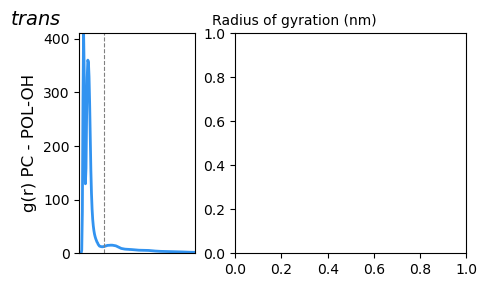

In [114]:
properties = {
    "rdf": [0, 410],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

isomers = ["trans", "cis"]

nrows = len(isomers)
ncols = len(properties)


fig = plt.figure(figsize=(12,6))
gs = GridSpec(nrows, ncols, width_ratios=[0.5, 1, 1, 1], hspace=0.1, wspace=0.2)

for i, iso in enumerate(isomers):
    for j, prop in enumerate(properties):
        formProp = POLPROP[prop]

        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ax.set_title(labels[iso], fontsize=14, horizontalalignment="left", loc="left", x=-0.6)  # - Replicas 0 1 2 3 4
        elif i == 0:
            ax.set_title(formProp["label"], fontsize=10, horizontalalignment="left", loc="left", x=-0.1)
        
        data = RDFGLOB_oh[iso][" 1 2 3 4"]["dprop"].copy()
        data = data[data["bin"] > data["bin"].min() + 0.02]
        data = data[data["distance"] <= 2.0]
        
        rdf = RDFGLOB_oh[iso][" 1 2 3 4"]["rdf"].copy()        
        if prop == "rdf":
            ax.plot(rdf["bin"], rdf["gr"], label=r, color=formProp["color"])
            ax.set_ylim(properties["rdf"])
            ax.set_ylabel(formProp["label"]+"-OH")
        else:
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["count"],
                    stat="count",
                    ax=ax,
                    binwidth=[POLPROP["distance"]["binwidth"], formProp["binwidth"]],
                    color=formProp["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            plot.collections[0].set_clim(0.01, 0.25)
            ax.axhline(y=data[prop].mean(), ls="--", color="black", lw=1.0)
            ax.set_ylim(formProp["xlim"])
            ax.set_ylabel("")
            
        ax.axvline(x=0.5, ls="--", color="gray", lw=.8)
            
            
        ax.set_xlabel(r"d$_{min}({at - at})$  (nm)")
        ax.set_xticks(np.arange(0, 2.5, 0.5))
        ax.set_xlim(0.1, 2.)
        
        
        if i != 1:
            ax.get_xaxis().set_visible(False)
        
        
        
    
SAVEFig.saveFig("Sizes_vs_distance_PBOH_PC.png")
plt.show()

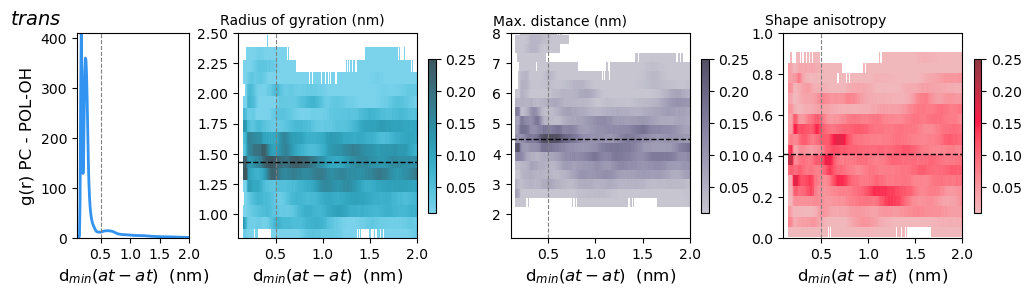

In [136]:
properties = {
    "rdf": [0, 410],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

isomers = ["trans"]

nrows = len(isomers)
ncols = len(properties)


fig = plt.figure(figsize=(12,8/3))
gs = GridSpec(nrows, ncols, width_ratios=[0.5, 1, 1, 1], hspace=0.1, wspace=0.25)

for i, iso in enumerate(isomers):
    for j, prop in enumerate(properties):
        formProp = POLPROP[prop]

        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ax.set_title(labels[iso], fontsize=14, horizontalalignment="left", loc="left", x=-0.6)  # - Replicas 0 1 2 3 4
        elif i == 0:
            ax.set_title(formProp["label"], fontsize=10, horizontalalignment="left", loc="left", x=-0.1)
        
        data = RDFGLOB_oh[iso][" 1 2 3 4"]["dprop"].copy()
        data = data[data["bin"] > data["bin"].min() + 0.02]
        data = data[data["distance"] <= 2.0]
        
        rdf = RDFGLOB_oh[iso][" 1 2 3 4"]["rdf"].copy()        
        if prop == "rdf":
            ax.plot(rdf["bin"], rdf["gr"], label=r, color=formProp["color"])
            ax.set_ylim(properties["rdf"])
            ax.set_ylabel(formProp["label"]+"-OH")
        else:
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["count"],
                    stat="count",
                    ax=ax,
                    binwidth=[POLPROP["distance"]["binwidth"], formProp["binwidth"]],
                    color=formProp["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            plot.collections[0].set_clim(0.01, 0.25)
            ax.axhline(y=data[prop].mean(), ls="--", color="black", lw=1.0)
            ax.set_ylim(formProp["xlim"])
            ax.set_ylabel("")
            
        ax.axvline(x=0.5, ls="--", color="gray", lw=.8)
            
            
        ax.set_xlabel(r"d$_{min}({at - at})$  (nm)")
        ax.set_xticks(np.arange(0, 2.5, 0.5))
        ax.set_xlim(0.1, 2.)
        
    
saveFig("Sizes_vs_distance_PBOH_PC_trans.png")
plt.show()

In [186]:
%%time 

isomers = ["trans", "cis", "s1"]
replicas = ["0", "1", "2", "3", "4"]
CMSizes = {}
kwargs_bins = {"rmin":.5, "rmax":3.05, "binwidth":0.05}

for iso in isomers:
    CMSizes[iso] = {}
    for r in replicas:
        print(f"Isomer {iso} - Replica {r}")
        CMSizes[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        data = pd.read_csv(f"{path_mol}/molprop.csv")
        data["time"] = data["frame"].apply(nbconfig.toTime, freq=1.0, t0=1.0)
        data["Rg"] *= 0.1
        data["dmax"] *= 0.1
        
        pol = data[data["idx"] != 0].copy()
        dist = get_distances_from_cm(0, data, box_in_frame)
        
        try:
            dprop = pd.DataFrame({
            "distance": dist["distance"].values * 0.1,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values,
            "idx": pol["idx"].values
            })
        except ValueError:
            print("distance shape:", dist.shape, len(dist))
            print("size shape", pol.shape, len(pol))
            print("WARNING: they do not have the same size.")
            
            if len(pol) < len(dist):
                dprop = pd.DataFrame({
                    "distance": dist["distance"].values[:len(pol)] * 0.1,
                    "Rg": pol["Rg"].values,
                    "k2": pol["k2"].values,
                    "dmax": pol["dmax"].values,
                    "time": pol["time"].values,
                    "frame": pol["frame"].values
                })
            elif len(dist) < len(pol):
                dprop = pd.DataFrame({
                    "distance": dist["distance"].values * 0.1,
                    "Rg": pol["Rg"].values[:len(dist)],
                    "k2": pol["k2"].values[:len(dist)],
                    "dmax": pol["dmax"].values[:len(dist)],
                    "time": pol["time"].values[:len(dist)],
                    "frame": pol["frame"].values[:len(dist)]
                })
            
            

        CMSizes[iso][r]["dprop"] = dprop
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, n_mol=72, **kwargs_bins) # rmin=1.0, rmax=3.05, binwidth=0.05
        rdf_bin = rdf.set_index("bin", inplace=False)
        # print(rdf_bin)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        dprop_binned.dropna(axis=0, inplace=True)
        
        # print(dprop_binned)
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        
        CMSizes[iso][r]["rdf"] = rdf
        CMSizes[iso][r]["dbind"] = dprop_binned
        
        print(80 * "=")

print("Finish")

Isomer trans - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.12 s
Searching connectivity - done in 1.90 s
Number of frames 2000
Isomer trans - Replica 1
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.89 s
Number of frames 2000
Isomer trans - Replica 2
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.12 s
Searching connectivity - done in 1.90 s
Number of frames 2000
Isomer trans - Replica 3
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.12 s
Searching connectivity - done in 1.94 s
Number of frames 2000
Isomer trans - Replica 4
Reading log file - done in 1.37 s
Reading fatomes file - done in 0.12 s
Searching connectivity - done in 1.92 s
Number of frames 2000
Isomer cis - Replica 0
Reading log file - done in 0.19 s
Reading fatomes file - done in 0.12 s
Searching connectivity - done in 1.91 s
Number of frames 2000
Isomer cis - Replica 1
Reading log file - done i

In [189]:
%%time 

#RDFGLOB = {}

replicas = ["0", "1", "2", "3", "4"]
isomers = ["trans", "cis", "s1"]
CMSizesGLOB = {}

for iso in isomers:
    CMSizesGLOB[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in replicas:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")

        CMSizesGLOB[iso][isoms] = {}
        data = CMSizes[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)

        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        # CMSTDCUM[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/6_prod_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, n_mol=72, **kwargs_bins)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        newData["count"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "frame"])
        
        # Save data
        CMSizesGLOB[iso][isoms]["dprop"] = newData
        CMSizesGLOB[iso][isoms]["rdf"] = rdf
        CMSizesGLOB[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: trans - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (74311, 8)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(2000, 3)
Isomer: trans - Replicas:  0 1
Numbers of frames: 2000 4000
2
Data size: (141368, 8)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(4000, 3)
Isomer: trans - Replicas:  0 1 2
Numbers of frames: 2000 6000
3
Data size: (218113, 8)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(6000, 3)
Isomer: trans - Replicas:  0 1 2 3
Numbers of frames: 2000 8000
4
Data size: (292139, 8)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(8000, 3)
Isomer: trans - Replicas:  0 1 2 3 4
Numbers of frames: 2000 10000
5
Data size: (371998, 8)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(10000, 3)

Isomer: cis - Replicas:  0
Numbers of frames: 2000 2000
1
Data size: (80361, 8)
rdf
Reading log file - done in 0.19 s
Number of frames 2000
(2000, 3)
Isomer: cis - Replicas:  0 1
Numbers of frames: 2000 4000
2
Dat

Image 14 saved!
/home/ovillegas/figures/figPapers/img_0014_Sizes_vs_CoM_PB_PC.png


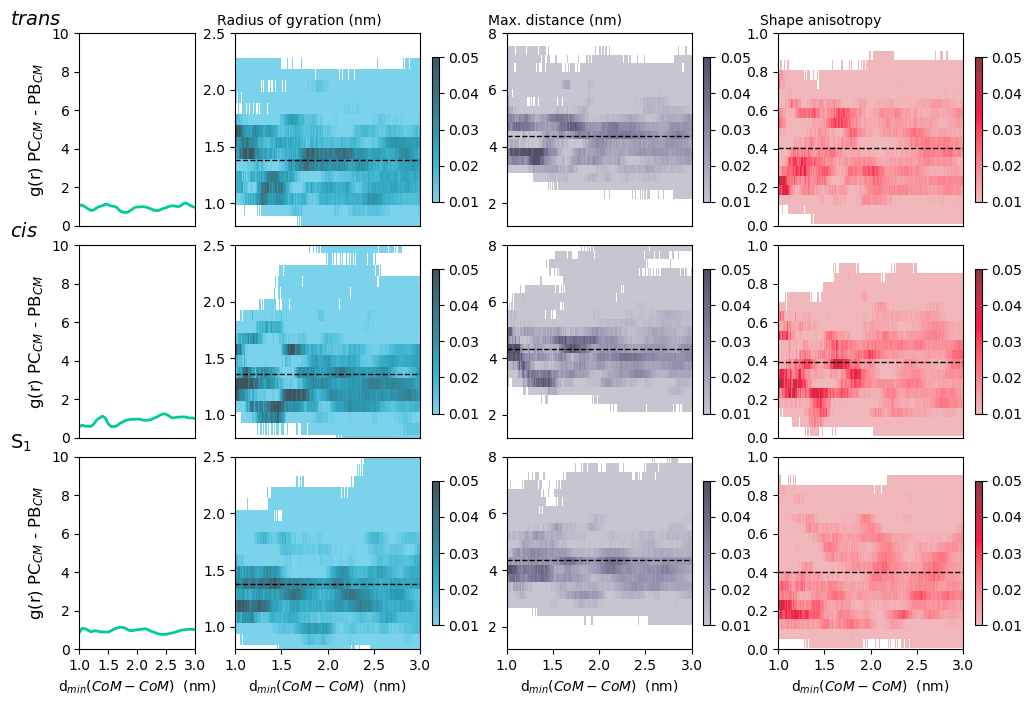

In [193]:
properties = {
    "rdf": [0, 10],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

isomers = ["trans", "cis", "s1"]

nrows = len(isomers)
ncols = len(properties)


fig = plt.figure(figsize=(12,8))
gs = GridSpec(nrows, ncols, width_ratios=[0.5, 1, 1, 1], hspace=0.1, wspace=0.2)

for i, iso in enumerate(isomers):
    for j, prop in enumerate(properties):
        formProp = POLPROP[prop.replace("rdf", "rdf_CM")]

        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ax.set_title(labels[iso], fontsize=14, horizontalalignment="left", loc="left", x=-0.6)  # - Replicas 0 1 2 3 4
        elif i == 0:
            ax.set_title(formProp["label"], fontsize=10, horizontalalignment="left", loc="left", x=-0.1)
        
        data = CMSizesGLOB[iso][" 0 1 2 3 4"]["dprop"].copy()
        data = data[data["distance"] >= 1.]
        
        rdf = CMSizesGLOB[iso][" 0 1 2 3 4"]["rdf"].copy()       
        if prop == "rdf":
            ax.plot(rdf["bin"], rdf["gr"], label=r, color=formProp["color"])
            ax.set_ylim(formProp["ylim"])
            ax.set_ylabel(formProp["label"])
        else:
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["count"],
                    stat="count",
                    ax=ax,
                    binwidth=[POLPROP["distance"]["binwidth"], formProp["binwidth"]],
                    color=formProp["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            plot.collections[0].set_clim(0.01, 0.05)
            ax.axhline(y=data[prop].mean(), ls="--", color="black", lw=1.0)
            ax.set_ylim(formProp["xlim"])
            ax.set_ylabel("")
            
        ax.axvline(x=0.5, ls="--", color="gray", lw=.8)
            
            
        ax.set_xlabel(r"d$_{min}({CoM - CoM})$  (nm)", fontsize=10)
        ax.set_xticks(np.arange(1, 3.5, 0.5))
        ax.set_xlim(1., 3.)
        
        
        if i != 2:
            ax.get_xaxis().set_visible(False)
        
        
        
    
SAVEFig.saveFig("Sizes_vs_CoM_PB_PC.png")
plt.show()

#### CM distances PB-OH

##### PBOH

In [226]:
%%time 

isomers = ["trans", "cis"]
replicas = ["0", "1", "2", "3", "4"]
CMSizes_oh = {}
kwargs_bins = {"rmin":.5, "rmax":3.05, "binwidth":0.05}

for iso in isomers:
    CMSizes_oh[iso] = {}
    for r in replicas:
        print(f"Isomer {iso} - Replica {r}")
        CMSizes_oh[iso][r] = {}
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        
        mol = STAMP(f"{path_mol}/DONNEES.in")
        box_in_frame = mol.box_in_frame
        
        data = pd.read_csv(f"{path_mol}/molprop.csv")
        # data = data[::10]
        data["time"] = data["frame"].apply(nbconfig.toTime, freq=.1, t0=1.0)
        data["Rg"] *= 0.1
        data["dmax"] *= 0.1
        
        pol = data[data["idx"] != 0].copy()
        # print(pol)
        dist = get_distances_from_cm(0, data, box_in_frame)
        # print(dist)
        
        try:
            dprop = pd.DataFrame({
            "distance": dist["distance"].values * 0.1,
            "Rg": pol["Rg"].values,
            "k2": pol["k2"].values,
            "dmax": pol["dmax"].values,
            "time": pol["time"].values,
            "frame": pol["frame"].values,
            "idx": pol["idx"].values
            })
        except ValueError:
            print("distance shape:", dist.shape, len(dist))
            print("size shape", pol.shape, len(pol))
            print("WARNING: they do not have the same size.")
            
            if len(pol) < len(dist):
                dprop = pd.DataFrame({
                    "distance": dist["distance"].values[:len(pol)] * 0.1,
                    "Rg": pol["Rg"].values,
                    "k2": pol["k2"].values,
                    "dmax": pol["dmax"].values,
                    "time": pol["time"].values,
                    "frame": pol["frame"].values
                })
            elif len(dist) < len(pol):
                dprop = pd.DataFrame({
                    "distance": dist["distance"].values * 0.1,
                    "Rg": pol["Rg"].values[:len(dist)],
                    "k2": pol["k2"].values[:len(dist)],
                    "dmax": pol["dmax"].values[:len(dist)],
                    "time": pol["time"].values[:len(dist)],
                    "frame": pol["frame"].values[:len(dist)]
                })
            
            

        CMSizes_oh[iso][r]["dprop"] = dprop
        box_in_frame[:, 0:3] *= 0.1
        
        rdf = rdf_from_dist(dprop, box_in_frame, n_mol=72, **kwargs_bins) # rmin=1.0, rmax=3.05, binwidth=0.05
        rdf_bin = rdf.set_index("bin", inplace=False)
        # print(rdf_bin)
        
        dprop_binned = dprop.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        dprop_binned.dropna(axis=0, inplace=True)
        
        # print(dprop_binned)
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        
        CMSizes_oh[iso][r]["rdf"] = rdf
        CMSizes_oh[iso][r]["dbind"] = dprop_binned
        
        print(80 * "=")
print("Finish")

Isomer trans - Replica 0
Reading log file - done in 0.72 s
Reading fatomes file - done in 0.14 s
Searching connectivity - done in 1.91 s
Number of frames 54418
Isomer trans - Replica 1
Reading log file - done in 0.25 s
Reading fatomes file - done in 0.78 s
Searching connectivity - done in 1.89 s
Number of frames 20000
Isomer trans - Replica 2
Reading log file - done in 0.25 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.88 s
Number of frames 20000
Isomer trans - Replica 3
Reading log file - done in 0.24 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.87 s
Number of frames 20000
Isomer trans - Replica 4
Reading log file - done in 0.24 s
Reading fatomes file - done in 0.11 s
Searching connectivity - done in 1.89 s
Number of frames 20000
Isomer cis - Replica 0
Reading log file - done in 0.67 s
Reading fatomes file - done in 0.13 s
Searching connectivity - done in 2.68 s
Number of frames 54494
Isomer cis - Replica 1
Reading log file - 

In [227]:
%%time 

#RDFGLOB = {}

replicas = ["0", "1", "2", "3", "4"]
isomers = ["trans", "cis"]
CMSizesGLOB_oh = {}
kwargs_bins = {"rmin":.5, "rmax":3.05, "binwidth":0.05}

for iso in isomers:
    CMSizesGLOB_oh[iso] = {}
    data_list = []
    box_list = []
    isoms = ""
    count_frames = 0
    for r in replicas:
        isoms += " " + r
        print(f"Isomer: {iso} - Replicas: {isoms}")

        CMSizesGLOB_oh[iso][isoms] = {}
        data = CMSizes_oh[iso][r]["dprop"].copy()
        data["bin"] = data["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        data.dropna(axis=0, inplace=True)
        frames_ndx = list(data["frame"].unique())
        data["frame"] += count_frames
        
        frames = data["frame"].unique()
        print("Numbers of frames:", len(frames), count_frames + len(frames))
        
        # data.drop(columns=["time", "frame"], inplace=True)
        
        data_list.append(data)
        print(len(data_list))
        newData = pd.concat(data_list, ignore_index=True)
        print("Data size:", newData.shape)

        #-------------
        # Calcule
        #-------------
        dfresume = newData.groupby("bin").agg(nbconfig.aggregation)
        dfresume.reset_index(inplace=True)
        # print(dfresume)
        # CMSTDCUM[iso][isoms] = dfresume.copy()
        #-------------
        # RDF
        #-------------
        print("rdf")
        path_mol = f"../exp.azob.stamp.3/{iso}/9_prod_OH_{r}"
        mol = STAMP(f"{path_mol}/DONNEES.in", loadConnect=False)
        box_in_frame = mol.box_in_frame[frames_ndx, 0:3]
        box_in_frame[:, 0:3] *= 0.1
        
        box_list.append(box_in_frame)
        newBoxs = np.concatenate(box_list)
        print(newBoxs.shape)
        
        rdf = rdf_from_dist(newData, newBoxs, n_mol=72, **kwargs_bins)
        rdf_bin = rdf.set_index("bin", inplace=False)
        
        dprop_binned = newData.copy()
        dprop_binned["distance"] = dprop_binned["distance"].apply(nbconfig.binned_distance, **kwargs_bins)
        
        dprop_binned.dropna(axis=0, inplace=True)
        
        dprop_binned["gr"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "gr"])
        dprop_binned["w"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "weight"])
        newData["count"] = dprop_binned["distance"].apply(lambda x: rdf_bin.loc[x, "frame"])
        
        # Save data
        CMSizesGLOB_oh[iso][isoms]["dprop"] = newData
        CMSizesGLOB_oh[iso][isoms]["rdf"] = rdf
        CMSizesGLOB_oh[iso][isoms]["dbinned"] = dprop_binned
        
        count_frames += len(frames)
        
        
        print(80 * "=")
        
    print("")
        
print("Finish!")

Isomer: trans - Replicas:  0
Numbers of frames: 16124 16124
1
Data size: (566132, 8)
rdf
Reading log file - done in 0.70 s
Number of frames 54418
(16124, 3)
Isomer: trans - Replicas:  0 1
Numbers of frames: 20000 36124
2
Data size: (1297481, 8)
rdf
Reading log file - done in 0.25 s
Number of frames 20000
(36124, 3)
Isomer: trans - Replicas:  0 1 2
Numbers of frames: 20000 56124
3
Data size: (2026579, 8)
rdf
Reading log file - done in 0.25 s
Number of frames 20000
(56124, 3)
Isomer: trans - Replicas:  0 1 2 3
Numbers of frames: 20000 76124
4
Data size: (2772168, 8)
rdf
Reading log file - done in 0.25 s
Number of frames 20000
(76124, 3)
Isomer: trans - Replicas:  0 1 2 3 4
Numbers of frames: 20000 96124
5
Data size: (3513574, 8)
rdf
Reading log file - done in 0.25 s
Number of frames 20000
(96124, 3)

Isomer: cis - Replicas:  0
Numbers of frames: 15749 15749
1
Data size: (662483, 8)
rdf
Reading log file - done in 0.71 s
Number of frames 54494
(15749, 3)
Isomer: cis - Replicas:  0 1
Number

Image 16 saved!
/home/ovillegas/figures/figPapers/img_0016_Sizes_vs_CoM_PBOH_PC.png


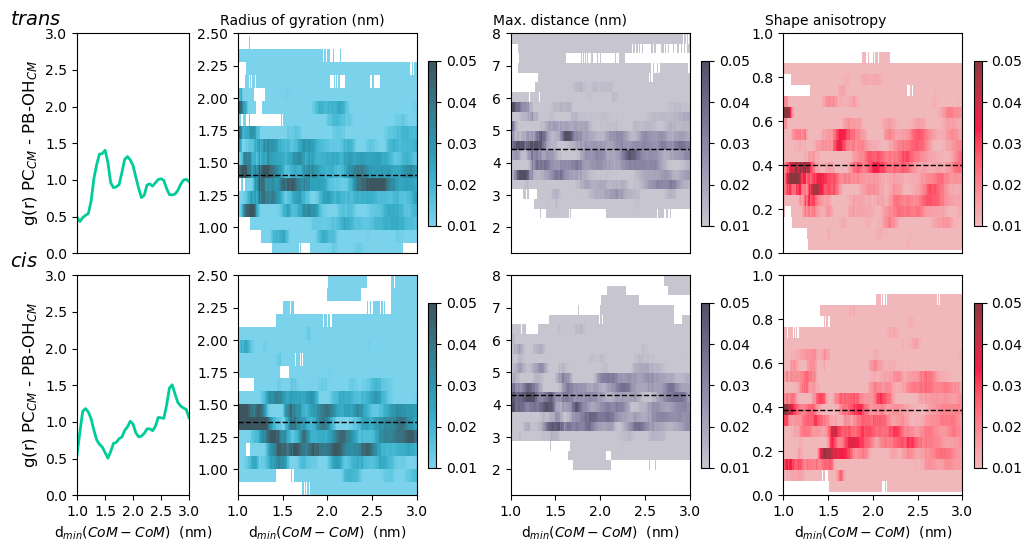

In [229]:
properties = {
    "rdf": [0, 3],
    "Rg": [0.0, 3.5],
    "dmax": [0., 8.5],
    "k2": [0.0, 1.]
}

isomers = ["trans", "cis"]

nrows = len(isomers)
ncols = len(properties)


fig = plt.figure(figsize=(12,6))
gs = GridSpec(nrows, ncols, width_ratios=[0.5, 1, 1, 1], hspace=0.1, wspace=0.25)

for i, iso in enumerate(isomers):
    for j, prop in enumerate(properties):
        formProp = POLPROP[prop.replace("rdf", "rdf_CM")]

        ax = fig.add_subplot(gs[i, j])
        if j == 0:
            ax.set_title(labels[iso], fontsize=14, horizontalalignment="left", loc="left", x=-0.6)  # - Replicas 0 1 2 3 4
        elif i == 0:
            ax.set_title(formProp["label"], fontsize=10, horizontalalignment="left", loc="left", x=-0.1)
        
        data = CMSizesGLOB_oh[iso][" 0 1 2 3 4"]["dprop"].copy()
        data = data[data["distance"] >= 1.]
        
        rdf = CMSizesGLOB_oh[iso][" 0 1 2 3 4"]["rdf"].copy()       
        if prop == "rdf":
            ax.plot(rdf["bin"], rdf["gr"], label=r, color=formProp["color"])
            ax.set_ylim(properties[prop])
            ax.set_ylabel(formProp["label"].replace("PB","PB-OH"))
        else:
            plot = sns.histplot(
                    data=data,
                    x="distance",
                    y=prop,
                    weights=1/data["count"],
                    stat="count",
                    ax=ax,
                    binwidth=[POLPROP["distance"]["binwidth"], formProp["binwidth"]],
                    color=formProp["color"],
                    cbar=True, cbar_kws=dict(shrink=.75)
                )
            
            plot.collections[0].set_clim(0.01, 0.05)
            ax.axhline(y=data[prop].mean(), ls="--", color="black", lw=1.0)
            ax.set_ylim(formProp["xlim"])
            ax.set_ylabel("")
            
        ax.axvline(x=0.5, ls="--", color="gray", lw=.8)
            
            
        ax.set_xlabel(r"d$_{min}({CoM - CoM})$  (nm)", fontsize=10)
        ax.set_xticks(np.arange(1, 3.5, 0.5))
        ax.set_xlim(1., 3.)
        
        
        if i != 1:
            ax.get_xaxis().set_visible(False)
        
        
        
    
SAVEFig.saveFig("Sizes_vs_CoM_PB_PC.png")
plt.show()

In [245]:
PROPvals = {
    "index": [],
    "columns": [],
    "data": [],
    "index_names": ["system", "environment"],
    "column_names": ["property", ""]
}

for iso in ["trans", "cis"]:
    PROPvals["index"].append((iso, "PB"))
    PROPvals["index"].append((iso, "PB-OH"))
    
PROPvals["index"].append(("", "PB"))

line_trans_pb = []
line_trans_pboh = []
line_cis_pb = []
line_cis_pboh = []
line_pb = []

for prop in ["Rg", "dmax", "k2"]:
    formatProp = POLPROP[prop]
    PROPvals["columns"].append((prop, "mean"))
    PROPvals["columns"].append((prop, "std"))
    for iso in ["trans", "cis"]:
        data = SIZESM[iso].copy()
        values = data[prop]
        
        data_oh = SIZESMoh[iso].copy()
        values_oh = data_oh[prop]
        
        # print(iso, prop, values.mean(), values.std())
        if iso == "trans":
            line_trans_pb.append(values.mean())
            line_trans_pb.append(values.std())
            line_trans_pboh.append(values_oh.mean())
            line_trans_pboh.append(values_oh.std())
        elif iso == "cis":
            line_cis_pb.append(values.mean())
            line_cis_pb.append(values.std())
            line_cis_pboh.append(values_oh.mean())
            line_cis_pboh.append(values_oh.std())

    data_pb0 = SIZESM["pb"].copy()
    values_pb0 = data_pb0[prop]
    line_pb.append(values_pb0.mean())
    line_pb.append(values_pb0.std())


In [246]:
PROPvals["data"] = np.array([
    line_trans_pb,
    line_trans_pboh,
    line_cis_pb,
    line_cis_pboh,
    line_pb
])

In [247]:
# PROPvals

In [248]:
PROPtab = pd.DataFrame.from_dict(PROPvals, orient='tight')
PROPtab

property                  Rg                dmax                  k2          
                        mean       std      mean       std      mean       std
system environment                                                            
trans  PB           1.377254  0.276626  4.344316  0.902090  0.405434  0.192234
       PB-OH        1.399358  0.283763  4.378532  0.921574  0.401543  0.183947
cis    PB           1.353180  0.284053  4.290865  0.919552  0.394578  0.186163
       PB-OH        1.378988  0.296299  4.334977  0.957785  0.388748  0.186710
       PB           1.393991  0.293549  4.342179  0.885639  0.418146  0.174793

In [249]:
PROPtab.style.format(precision=3).to_latex(
    "propSizeTab_PBOH.tex",
    label="tab:propSizePBOH",
    caption="Average values of the system's PB-OH chains."
)